### Further clean DELINQUENCY variables (round to 2 decimals / integerize / ...)

In [1]:
import gc
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
pd.options.display.float_format = "{:,.4f}".format
import random
import sys
sys.path.append("../../")
import time
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")
from pandarallel import pandarallel
from tqdm import tqdm

In [2]:
from pathlib import Path
rootpath = Path.cwd().parent
sys.path.append(os.path.join(rootpath))

In [3]:
from utils.common import *
from utils.constants import *
from utils.eda_helpers import (
    plot_missing_proportion_barchart, get_cols, plot_scatterplot, plot_target_check, print_percentile,
    plot_int_feature_distribution, plot_train_test_distribution, check_overlap_missing,
    insert_row_number, plot_sampled_time_series, describe_all, check_psi, plot_heatmap, check_summary
)
from utils.eval_helpers import (
    plot_roc_curves, plot_feature_importance, check_roc_auc,
    amex_metric, get_final_metric_df, amex_metric_np, lgb_amex_metric
)
from utils.extraction_helpers import read_file
from utils.feature_group import (
    CATEGORY_COLUMNS, CONTINUOUS_COLUMNS, NON_FEATURE_COLUMNS
)
from utils.preprocess_helpers import *

In [4]:
%load_ext autoreload
%autoreload

In [5]:
gc.collect()

36

In [6]:
START = time.time()

### Setup

In [7]:
%%time
train = read_file(f"../{RAW_DATA_PATH}/train_parquet_rounded/delinquency1.parquet")
test = read_file(f"../{RAW_DATA_PATH}/test_parquet_rounded/delinquency1.parquet")

Shape of data: (5531451, 57)
Shape of data: (11363762, 56)
CPU times: user 23.1 s, sys: 13.1 s, total: 36.2 s
Wall time: 7.22 s


In [8]:
# %%time
# labels = pd.read_csv(f"../{RAW_DATA_PATH}/train_labels.csv")
# if "target" not in train.columns:
#     train = train.merge(labels, on="customer_ID", how="left")

In [9]:
%%time
public_test, private_test = split_public_private(test)

Public size: 5719469, Private size: 5644293
CPU times: user 6.76 s, sys: 1 s, total: 7.76 s
Wall time: 7.72 s


In [10]:
del test

In [11]:
train.shape, public_test.shape, private_test.shape

((5531451, 57), (5719469, 56), (5644293, 56))

In [12]:
df_list = [train, public_test, private_test]

In [13]:
d_variables = get_cols(train, ["D_"])
print(sorted(d_variables))

['D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_49', 'D_50', 'D_51', 'D_52', 'D_53', 'D_54', 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_61', 'D_62', 'D_63', 'D_64', 'D_65', 'D_66', 'D_68', 'D_69', 'D_70', 'D_71', 'D_72', 'D_73', 'D_74', 'D_75', 'D_76', 'D_77', 'D_78', 'D_79', 'D_80', 'D_81', 'D_82', 'D_83', 'D_84', 'D_86', 'D_87', 'D_88', 'D_89', 'D_91', 'D_92', 'D_93', 'D_94', 'D_96']


In [14]:
train["target"].mean()

0.24909720794778803

In [15]:
# for df in df_list:
#     insert_row_number(df)

In [16]:
pandarallel.initialize(nb_workers=12, progress_bar=False, use_memory_fs=False)

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [17]:
# train_corr = train.loc[:, train.columns[4:-1]].corr()
# train_corr.to_csv(f"../{RAW_DATA_PATH}/pre_clean_train_delinquency1_corr.csv", index=False)

In [18]:
# train_corr = read_file(f"../{RAW_DATA_PATH}/pre_clean_train_delinquency1_corr.csv")
# train_corr.index = train_corr.columns

### Rounding

#### Round to 2 decimals

In [19]:
# %%time
# # Skip some columns
# col_to_round = list(set(d_variables) - set())
# d_variables_psi_list = []
# for col in tqdm(col_to_round):
#     try:
#         pre_round = check_psi(df_list, col)[1]
#         df_list = round_dfs(df_list, col, decimals=2, add_new_col=False, nb_workers=8)
#         post_round = check_psi(df_list, col)[1]
#         d_variables_psi_list.append((col, pre_round, post_round))
#     except:
#         print(f"Skip column {col}")

In [20]:
# d_psi_df = pd.DataFrame(d_variables_psi_list, columns=["feature", "psi_before", "psi_after"])
# sorted(d_psi_df.loc[d_psi_df["psi_before"] < d_psi_df["psi_after"], "feature"].tolist())

In [21]:
# %%time
# train = df_list[0]
# test = pd.concat(df_list[1:], axis=0)
# test = test.sort_values(by=["customer_ID", "S_2"]).reset_index(drop=True)
# train.to_parquet(f"../{RAW_DATA_PATH}/train_parquet_rounded/delinquency1.parquet")
# test.to_parquet(f"../{RAW_DATA_PATH}/test_parquet_rounded/delinquency1.parquet")

### D_92 - D_96 => D_99

In [22]:
for df in df_list:
    df["D_92"] = df["D_92"].replace(2, 1)
    df["D_99"] = df[["D_92", "D_93", "D_94", "D_96"]].sum(axis=1)

0 null count, 0.000 null proportion
nan of the targets have label = 1


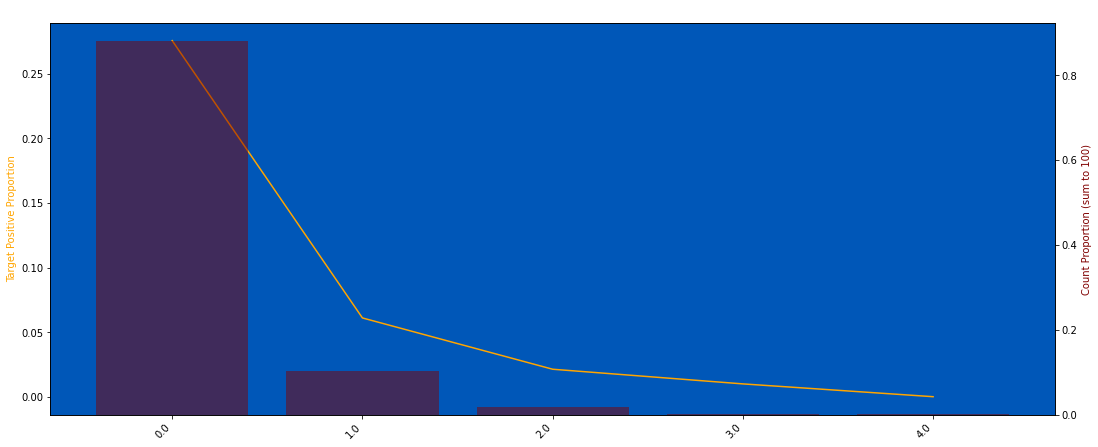

In [23]:
plot_target_check(train, "D_99", q=50, use_raw_bin=True, nunique_thr=10000, strfy_x=True, without_drop_tail=True)

In [24]:
col_to_drop = ["D_92", "D_93", "D_94", "D_96"]

In [25]:
for df in tqdm(df_list):
    df.drop(columns=col_to_drop, errors="ignore", inplace=True)

100%|██████████| 3/3 [00:04<00:00,  1.36s/it]


### D_86, D_88, D_89 => D_888

In [26]:
for df in df_list:
    df["D_88"] = np.where(df["D_88"].isnull(), 0, 1)
    df["D_89"] = np.where(df["D_89"] > 0, 1, 0)
    df["D_888"] = df["D_88"] + df["D_89"] - df["D_86"] + 1

0 null count, 0.000 null proportion
nan of the targets have label = 1


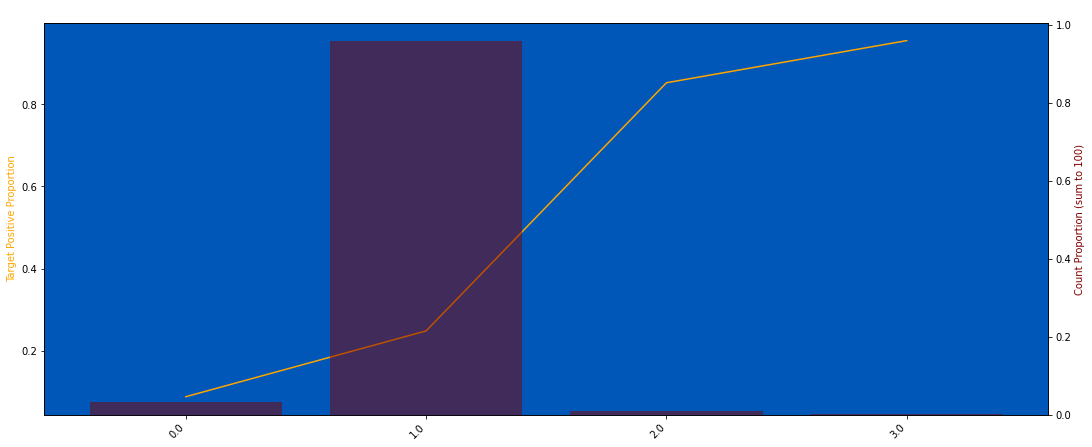

In [27]:
plot_target_check(train, "D_888", q=50, use_raw_bin=True, nunique_thr=10000, strfy_x=True, without_drop_tail=True)

In [28]:
col_to_drop = ["D_86", "D_88", "D_89"]

In [29]:
for df in tqdm(df_list):
    df.drop(columns=col_to_drop, errors="ignore", inplace=True)

100%|██████████| 3/3 [00:03<00:00,  1.31s/it]


### D_81, D_83 => D_813

In [30]:
for df in df_list:
    df = clip_col(df, "D_81", top_value=3, add_new_col=False)
    df = clip_col(df, "D_83", top_value=2, add_new_col=False)
    df["D_813"] = df["D_81"] + df["D_83"]

197541 null count, 0.036 null proportion
0.4286 of the targets have label = 1


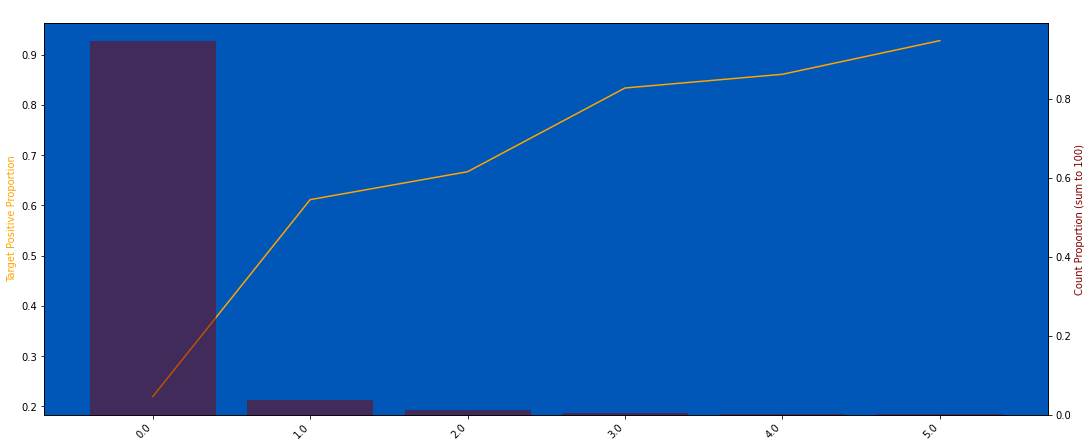

In [31]:
plot_target_check(train, "D_813", q=50, use_raw_bin=True, nunique_thr=10000, strfy_x=True, without_drop_tail=True)

### Drop columns

In [32]:
for df in tqdm(df_list):
    df.drop(columns=["D_45", "D_66", "D_73"], errors="ignore", inplace=True)

100%|██████████| 3/3 [00:03<00:00,  1.28s/it]


### D_39 @Continuous, Increasing

In [33]:
%%time
for df in df_list:
    df["D_39"] = ((df["D_39"] - 0.02) / 0.0291).apply(np.floor).replace(-1, np.nan)

CPU times: user 642 ms, sys: 564 ms, total: 1.21 s
Wall time: 1.2 s


In [34]:
print_percentile(df_list, "D_39", 99.9)

99.9th percentile:
train : 91.0
public test : 91.0
private test : 91.0


In [35]:
for df in df_list:
    df = clip_col(df, "D_39", top_value=91, add_new_col=False)

3053463 null count, 0.552 null proportion
0.1787 of the targets have label = 1


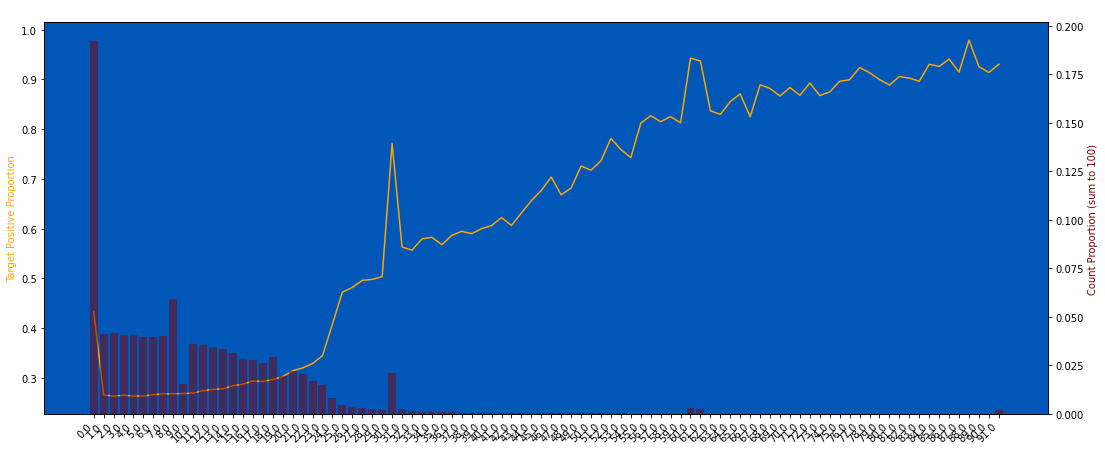

In [36]:
plot_target_check(train, "D_39", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True)

In [37]:
# describe_all(df_list, "D_39").loc["null_proportion"]

In [38]:
# plot_train_test_distribution(df_list, "D_39", nunique_thr=1000)

### D_41 @Continuous, Increasing

In [39]:
print_percentile(df_list, "D_41", 99.9)

99.9th percentile:
train : 2.15
public test : 2.09
private test : 2.08


In [40]:
for df in df_list:
    df = clip_col(df, "D_41", top_value=2.1, add_new_col=False)

In [41]:
for df in df_list:
    df["D_41"] = df["D_41"].replace(0, np.nan)

4813316 null count, 0.870 null proportion
0.2086 of the targets have label = 1


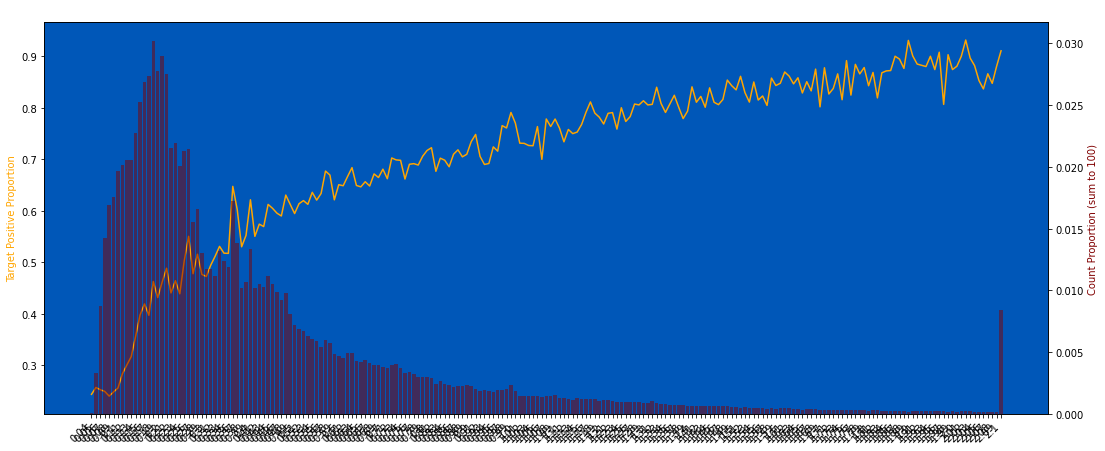

In [42]:
plot_target_check(train, "D_41", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True)

In [43]:
# describe_all(df_list, "D_41").loc["null_proportion"]

In [44]:
# plot_train_test_distribution(df_list, "D_41", nunique_thr=1000)

### D_42 @Continuous, Increasing

In [45]:
print_percentile(df_list, "D_42", 99)

99th percentile:
train : 1.0
public test : 1.04
private test : 1.11


In [46]:
for df in df_list:
    df = clip_col(df, "D_42", top_value=1, add_new_col=False)

4740137 null count, 0.857 null proportion
0.2075 of the targets have label = 1


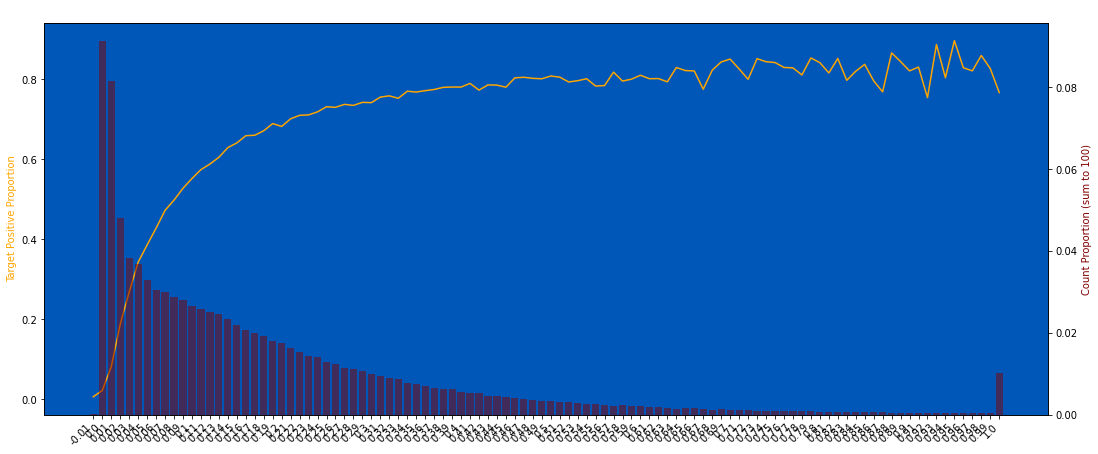

In [47]:
plot_target_check(train, "D_42", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True)

In [48]:
# plot_train_test_distribution(df_list, "D_42", nunique_thr=1000)

In [49]:
# describe_all(df_list, "D_42").loc["null_proportion"]

### D_43 @Continuous, Increasing

In [50]:
# plot_target_check(train, "D_43", q=50, use_raw_bin=True)

In [51]:
print_percentile(df_list, "D_43", 99.9)

99.9th percentile:
train : 2.12
public test : 2.1
private test : 1.92


In [52]:
for df in df_list:
    df = clip_col(df, "D_43", top_value=2, add_new_col=False)

1658396 null count, 0.300 null proportion
0.1673 of the targets have label = 1


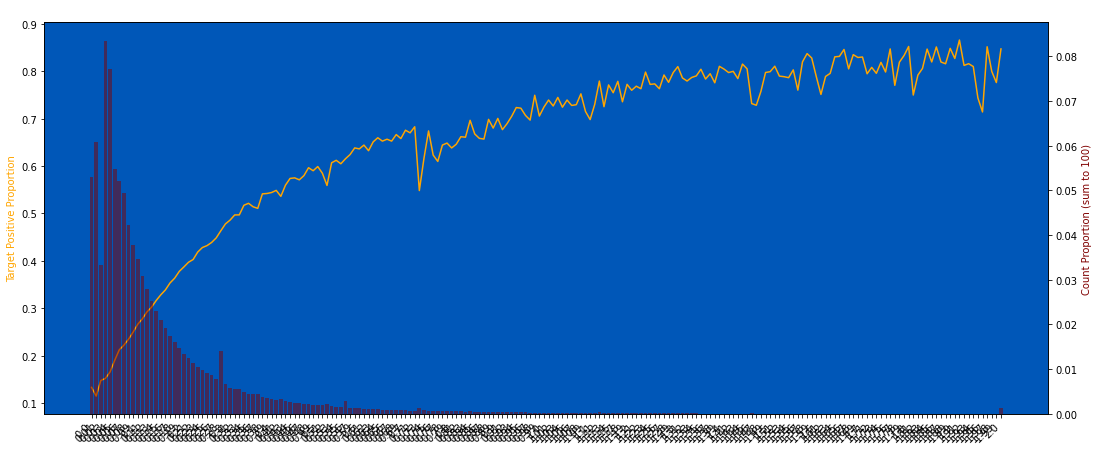

In [53]:
plot_target_check(train, "D_43", q=50, use_raw_bin=True, nunique_thr=10000, strfy_x=True, without_drop_tail=True)

In [54]:
# plot_train_test_distribution(df_list, "D_43", nunique_thr=1000)

### D_44 @Integer, Increasing

In [55]:
# plot_target_check(train, "D_44", q=50, use_raw_bin=True, nunique_thr=1000)

In [56]:
print_percentile(df_list, "D_44", 99.99)

99.99th percentile:
train : 2.38
public test : 2.5
private test : 2.5


In [57]:
%%time
for df in df_list:
    df["D_44"] = (df["D_44"] * 8).round(0)

CPU times: user 568 ms, sys: 410 ms, total: 978 ms
Wall time: 976 ms


In [58]:
print_percentile(df_list, "D_44", 99.8)

99.8th percentile:
train : 12.0
public test : 12.0
private test : 12.0


In [59]:
for df in df_list:
    df = clip_col(df, "D_44", top_value=10, add_new_col=False)

274319 null count, 0.050 null proportion
0.2406 of the targets have label = 1


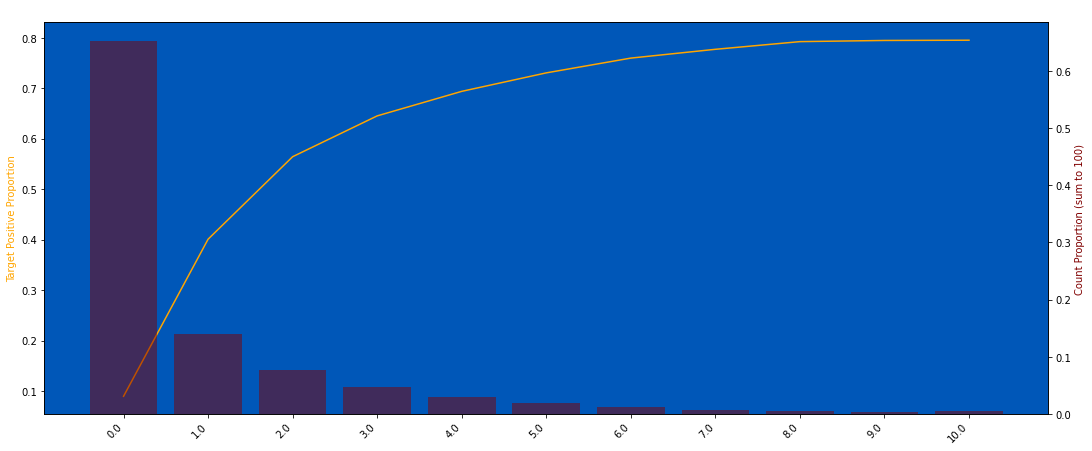

In [60]:
plot_target_check(train, "D_44", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True)

In [61]:
# plot_train_test_distribution(df_list, "D_44", nunique_thr=1000, without_drop_tail=True)

In [62]:
# describe_all(df_list, "D_44").loc["null_proportion"]

### D_46 (KIV) Similar pattern with P_3, can try to feature cross them.

In [63]:
print_percentile(df_list, "D_46", 99.9)

99.9th percentile:
train : 1.68
public test : 1.71
private test : 1.72


In [64]:
for df in df_list:
    df = clip_col(df, "D_46", top_value=1.7, add_new_col=False)
    df = clip_col(df, "D_46", btm_value=-0.7, add_new_col=False)

1211699 null count, 0.219 null proportion
0.1940 of the targets have label = 1


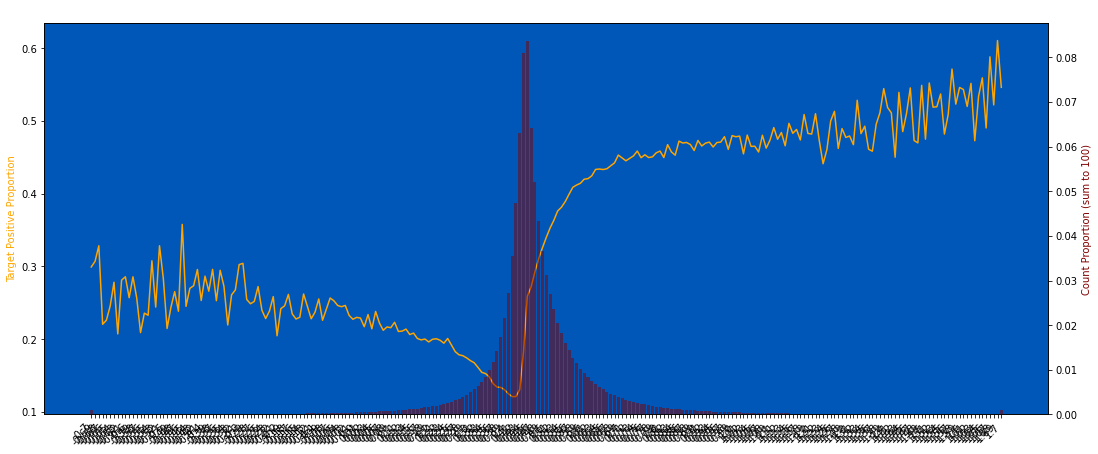

In [65]:
plot_target_check(train, "D_46", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

In [66]:
# plot_train_test_distribution(df_list, "D_46", nunique_thr=8000)

In [67]:
# describe_all(df_list, "D_46").loc["null_proportion"]

### D_47 @Continuous, Decreasing

In [68]:
# plot_target_check(train, "D_47", q=50, use_raw_bin=True)

In [69]:
describe_all(df_list, "D_47")

,train,public test,private test
count,"5,531,451.0000","5,719,469.0000","5,644,293.0000"
mean,0.4017,0.3908,0.3909
std,0.2347,0.2326,0.2325
min,-0.0300,-0.0300,-0.0300
25%,0.2300,0.2200,0.2200
50%,0.3800,0.3600,0.3600
75%,0.5600,0.5400,0.5400
max,1.6400,1.4800,1.5100
null_proportion,0.0000,0.0000,0.0000


In [70]:
print_percentile(df_list, "D_47", 99.975)

99.975th percentile:
train : 1.25
public test : 1.24
private test : 1.24


In [71]:
for df in df_list:
    df = clip_col(df, "D_47", top_value=1.24, add_new_col=False)

0 null count, 0.000 null proportion
nan of the targets have label = 1


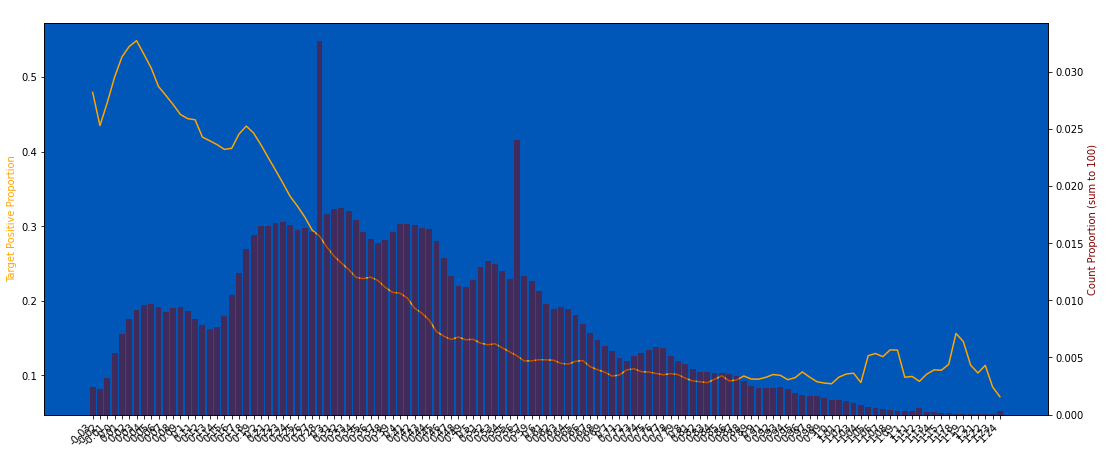

In [72]:
plot_target_check(train, "D_47", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True)

In [73]:
# plot_train_test_distribution(df_list, "D_47", nunique_thr=8000, without_drop_tail=True)

### D_48  @Continuous, Increasing

In [74]:
# plot_target_check(train, "D_48", q=50, use_raw_bin=True)

In [75]:
describe_all(df_list, "D_48")

,train,public test,private test
count,"4,812,726.0000","4,997,589.0000","4,919,037.0000"
mean,0.3764,0.3760,0.3664
std,0.3264,0.3284,0.3262
min,-0.0100,-0.0100,-0.0100
25%,0.0800,0.0800,0.0700
50%,0.2800,0.2800,0.2600
75%,0.6600,0.6700,0.6500
max,8.9700,7.5400,6.7900
null_proportion,0.1299,0.1262,0.1285


In [76]:
print_percentile(df_list, "D_48", 99.95)

99.95th percentile:
train : 1.39
public test : 1.41
private test : 1.36


In [77]:
for df in df_list:
    df = clip_col(df, "D_48", top_value=1.4, add_new_col=False)

718725 null count, 0.130 null proportion
0.1221 of the targets have label = 1


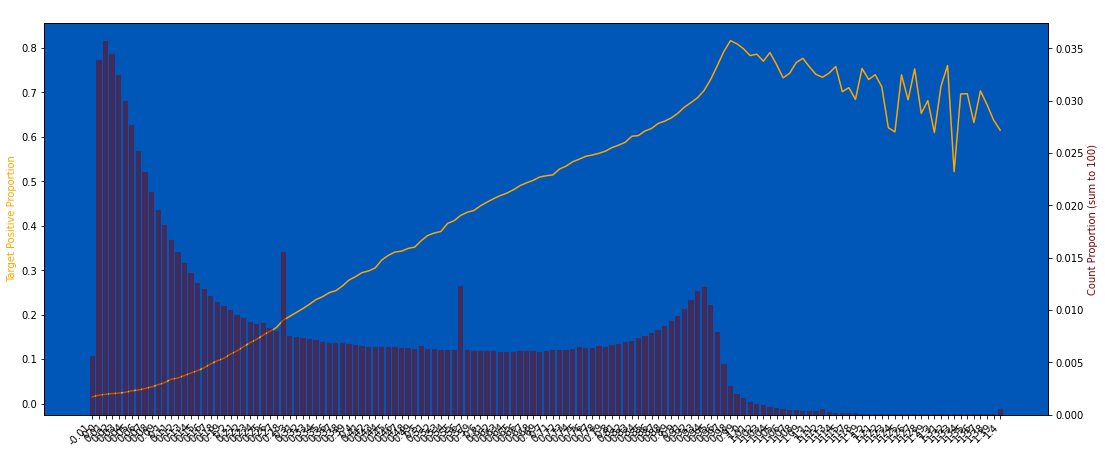

In [78]:
plot_target_check(train, "D_48", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True)

In [79]:
# plot_train_test_distribution(df_list, "D_48", nunique_thr=8000, without_drop_tail=True)

### D_49 @Continuous, Decreasing

In [80]:
print_percentile(df_list, "D_49", 99.9)

99.9th percentile:
train : 2.04
public test : 2.0
private test : 2.15


In [81]:
for df in df_list:
    df = clip_col(df, "D_49", top_value=2, add_new_col=False)

In [82]:
# for df in tqdm(df_list): 
#     df["D_49"] = df["D_49"].parallel_apply(lambda x: manual_stack(x, start=0, stack_interval=0.03, denom=100))

4985917 null count, 0.901 null proportion
0.2162 of the targets have label = 1


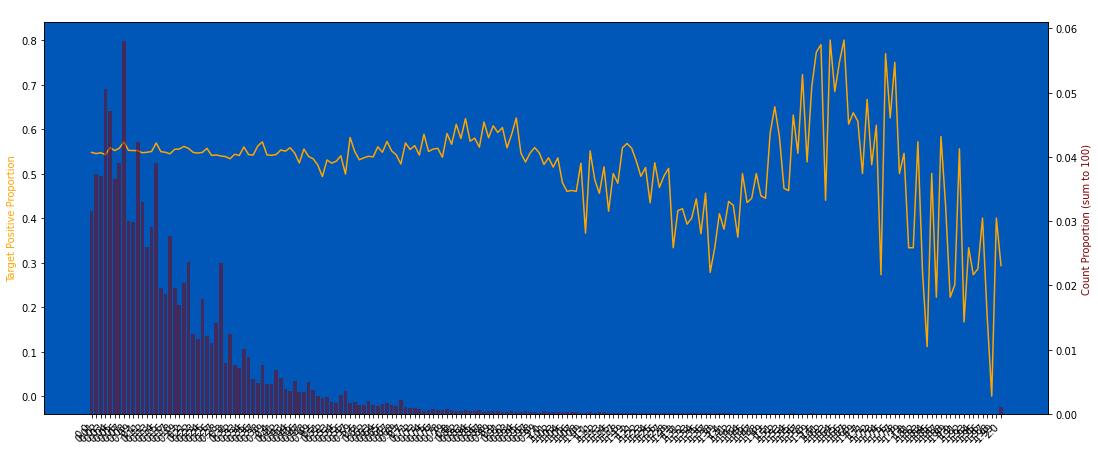

In [83]:
plot_target_check(train, "D_49", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True)

In [84]:
# plot_train_test_distribution(df_list, "D_49", nunique_thr=1000)

### D_50 @Continuous, Decreasing

In [85]:
# plot_target_check(train, "D_50", q=50, use_raw_bin=True)

In [86]:
describe_all(df_list, "D_50")

,train,public test,private test
count,"2,389,049.0000","2,448,088.0000","2,432,928.0000"
mean,0.1694,0.1784,0.1833
std,0.6338,0.7785,0.7363
min,-306.4900,-207.4500,-18.4800
25%,0.0600,0.0600,0.0600
50%,0.1000,0.1100,0.1100
75%,0.1800,0.1900,0.1900
max,244.0400,354.5300,265.2700
null_proportion,0.5681,0.5720,0.5690


In [87]:
print_percentile(df_list, "D_50", 99.7)

99.7th percentile:
train : 2.27
public test : 2.59
private test : 2.79


In [88]:
for df in df_list:
    df = clip_col(df, "D_50", btm_value=-0.14, add_new_col=False)
    df = clip_col(df, "D_50", top_value=2.5, add_new_col=False)

3142402 null count, 0.568 null proportion
0.3005 of the targets have label = 1


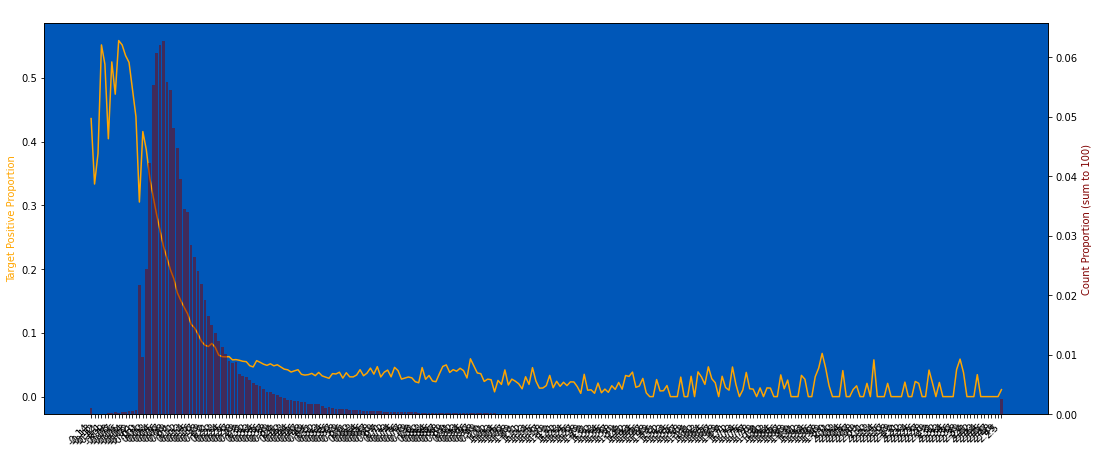

In [89]:
plot_target_check(train, "D_50", q=50, use_raw_bin=True, nunique_thr=10000, strfy_x=True, without_drop_tail=True)

In [90]:
# plot_train_test_distribution(df_list, "D_50", nunique_thr=10000, without_drop_tail=True)

In [91]:
# describe_all(df_list, "D_50").loc["null_proportion"]

### D_51 @Integer, Decreasing

In [92]:
# plot_target_check(train, "D_51", q=50, use_raw_bin=True, nunique_thr=10000)

In [93]:
for df in df_list:
    df["D_51"] = (df["D_51"] * 3).round(0)

In [94]:
print_percentile(df_list, "D_51", 99.91)

99.91th percentile:
train : 5.0
public test : 5.0
private test : 5.0


In [95]:
for df in df_list:
    df = clip_col(df, "D_51", top_value=5, add_new_col=False)

0 null count, 0.000 null proportion
nan of the targets have label = 1


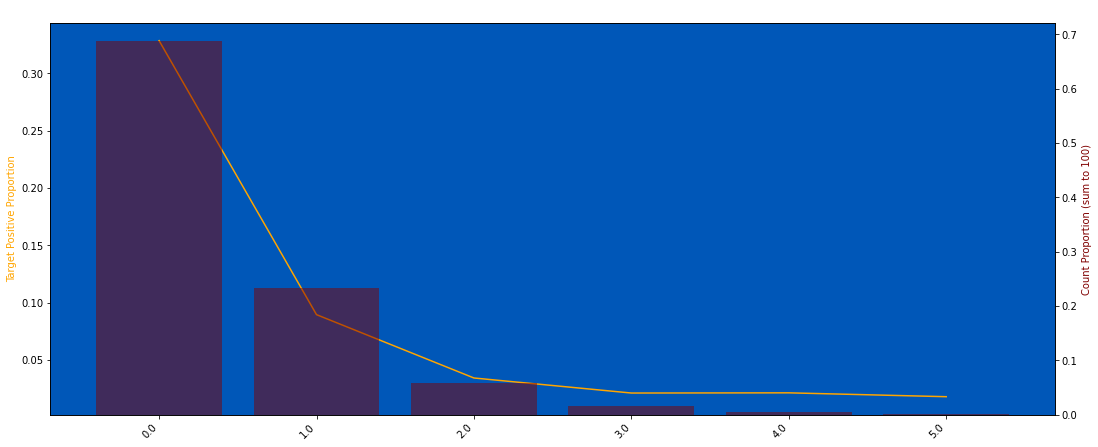

In [96]:
plot_target_check(train, "D_51", q=50, use_raw_bin=True, nunique_thr=10000, strfy_x=True, without_drop_tail=True)

In [97]:
# plot_train_test_distribution(df_list, "D_51", nunique_thr=1000, without_drop_tail=True)

In [98]:
# describe_all(df_list, "D_51").loc["null_proportion"]

### D_52 @Continuous, Decreasing

In [99]:
# plot_target_check(train, "D_52", q=50, use_raw_bin=True)

29563 null count, 0.005 null proportion
0.3523 of the targets have label = 1


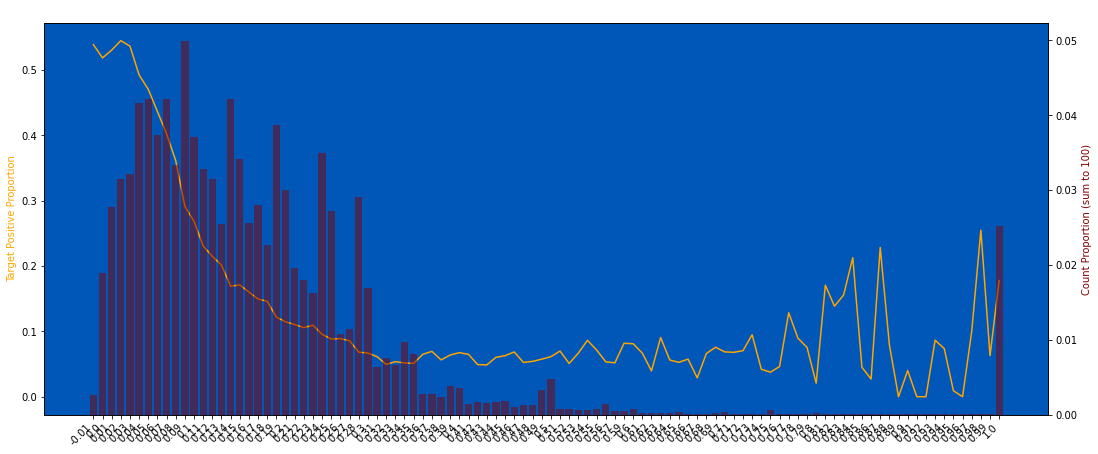

In [100]:
plot_target_check(train, "D_52", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True)

In [101]:
# plot_train_test_distribution(df_list, "D_52", nunique_thr=1000, without_drop_tail=True)

### D_53 @Continuous, Increasing

In [102]:
# plot_target_check(train, "D_53", q=50, use_raw_bin=True)

In [103]:
describe_all(df_list, "D_53")

,train,public test,private test
count,"1,446,866.0000","1,507,100.0000","1,477,687.0000"
mean,0.0712,0.0749,0.0751
std,0.2027,0.2070,0.2036
min,0.0000,0.0000,0.0000
25%,0.0000,0.0000,0.0000
50%,0.0100,0.0100,0.0100
75%,0.0400,0.0500,0.0500
max,7.9000,7.7200,7.2200
null_proportion,0.7384,0.7365,0.7382


In [104]:
print_percentile(df_list, "D_53", 99.9)

99.9th percentile:
train : 2.23
public test : 2.19
private test : 2.12


In [105]:
for df in df_list:
    df = clip_col(df, "D_53", top_value=2.25, add_new_col=False)

4084585 null count, 0.738 null proportion
0.1836 of the targets have label = 1


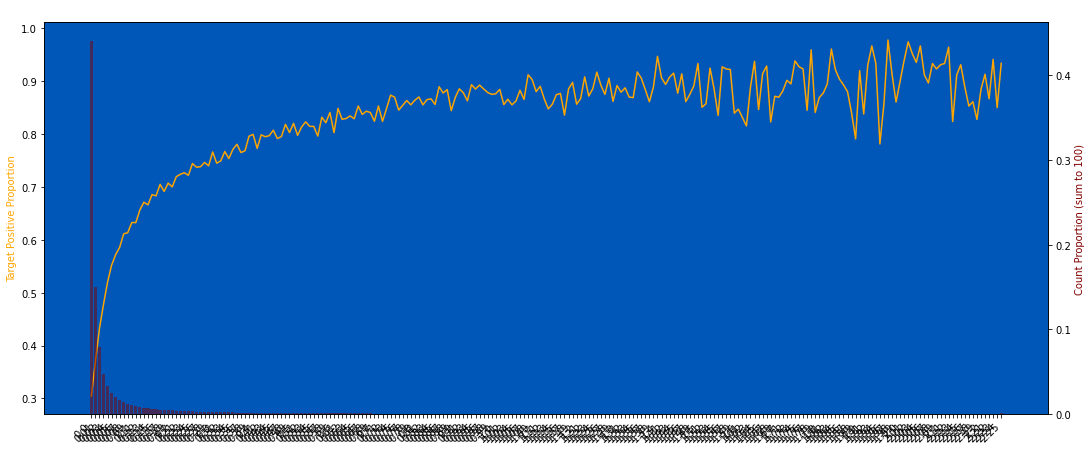

In [106]:
plot_target_check(train, "D_53", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

In [107]:
# plot_train_test_distribution(df_list, "D_53", nunique_thr=1000)

### D_54 @Binary, Decreasing

In [108]:
# plot_target_check(train, "D_54", q=100, use_raw_bin=True)

In [109]:
for df in df_list:
    df["D_54"] = df["D_54"].round(0)

2016 null count, 0.000 null proportion
0.3562 of the targets have label = 1


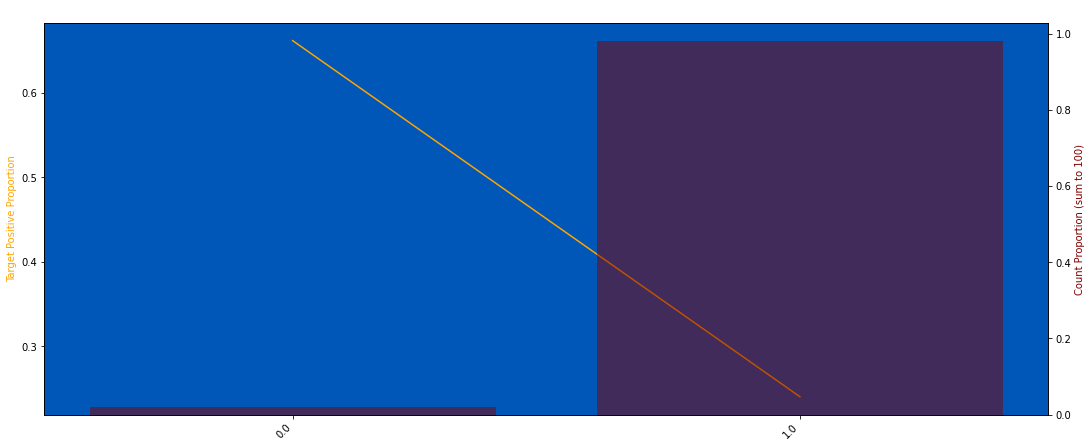

In [110]:
plot_target_check(train, "D_54", q=100, use_raw_bin=True, nunique_thr=4000, strfy_x=True, without_drop_tail=True)

In [111]:
# plot_train_test_distribution(df_list, "D_54", without_drop_tail=True)

In [112]:
# describe_all(df_list, "D_54").loc["null_proportion"]

### D_55 @Continuous, Increasing

In [113]:
# plot_target_check(train, "D_55", q=50, use_raw_bin=True)

In [114]:
print_percentile(df_list, "D_55", 99.9)

99.9th percentile:
train : 1.11
public test : 1.11
private test : 1.11


In [115]:
for df in df_list:
    df = clip_col(df, "D_55", top_value=1.11, add_new_col=False)

184803 null count, 0.033 null proportion
0.1759 of the targets have label = 1


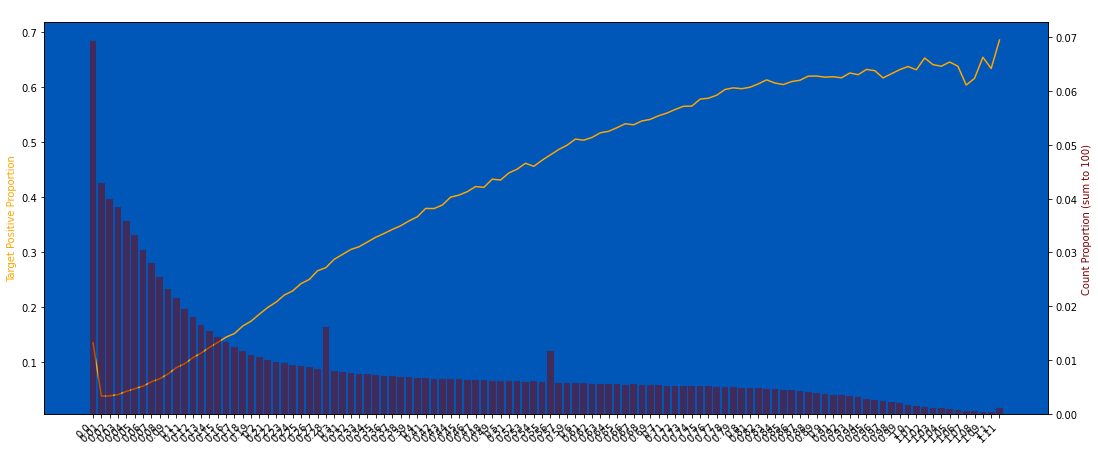

In [116]:
plot_target_check(train, "D_55", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True)

In [117]:
# plot_train_test_distribution(df_list, "D_55", nunique_thr=1000)

### D_56 @Continuous, Decreasing

In [118]:
# plot_target_check(train, "D_56", q=50, use_raw_bin=True)

In [119]:
print_percentile(df_list, "D_56", 99.9)

99.9th percentile:
train : 2.0
public test : 2.06
private test : 2.08


In [120]:
for df in df_list:
    df = clip_col(df, "D_56", top_value=2, add_new_col=False)

2990943 null count, 0.541 null proportion
0.3282 of the targets have label = 1


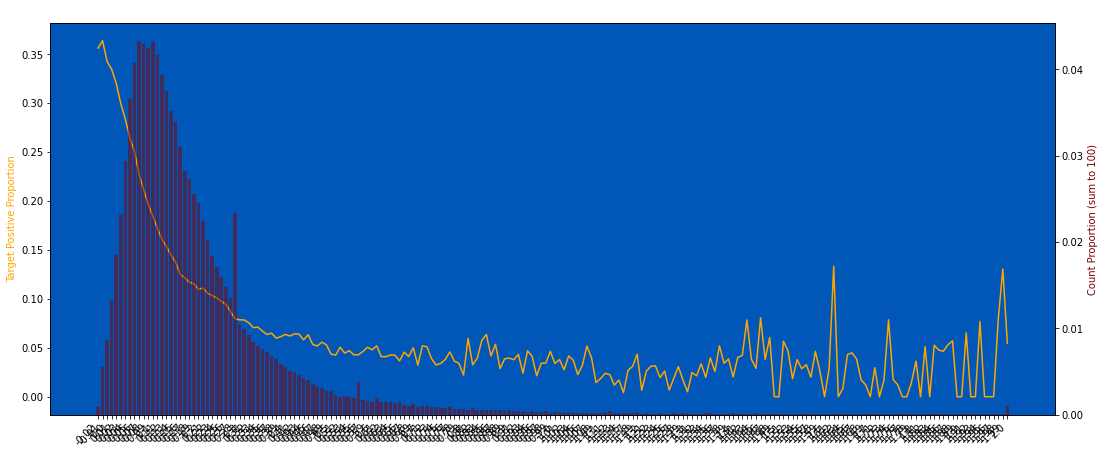

In [121]:
plot_target_check(train, "D_56", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

In [122]:
# plot_train_test_distribution(df_list, "D_56", nunique_thr=1000)

### D_58 @Continuous, Increasing

In [123]:
for df in df_list:
    df["D_58"] = df["D_58"].replace(0, np.nan)

In [124]:
describe_all(df_list, "D_58")

,train,public test,private test
count,"3,168,715.0000","3,274,072.0000","3,167,136.0000"
mean,0.3672,0.3702,0.3675
std,0.2462,0.2470,0.2458
min,0.0100,0.0100,0.0100
25%,0.1600,0.1600,0.1600
50%,0.3200,0.3300,0.3300
75%,0.5200,0.5300,0.5200
max,1.2600,1.2600,1.2600
null_proportion,0.4271,0.4276,0.4389


2362736 null count, 0.427 null proportion
0.0654 of the targets have label = 1


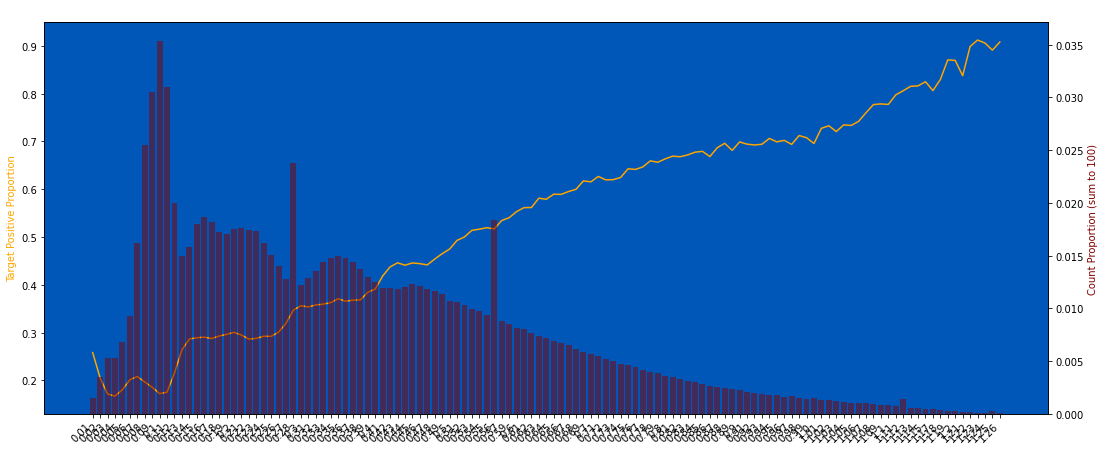

In [125]:
plot_target_check(train, "D_58", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

In [126]:
# plot_train_test_distribution(df_list, "D_58", nunique_thr=1000)

### D_59 (Drop)

In [127]:
%%time
for df in tqdm(df_list):
    df.drop(columns="D_59", errors="ignore", inplace=True)

100%|██████████| 3/3 [00:03<00:00,  1.23s/it]

CPU times: user 2.17 s, sys: 1.51 s, total: 3.68 s
Wall time: 3.68 s


### D_60 @Continuous, n

In [128]:
# plot_target_check(train, "D_60", q=50, use_raw_bin=True)

0 null count, 0.000 null proportion
nan of the targets have label = 1


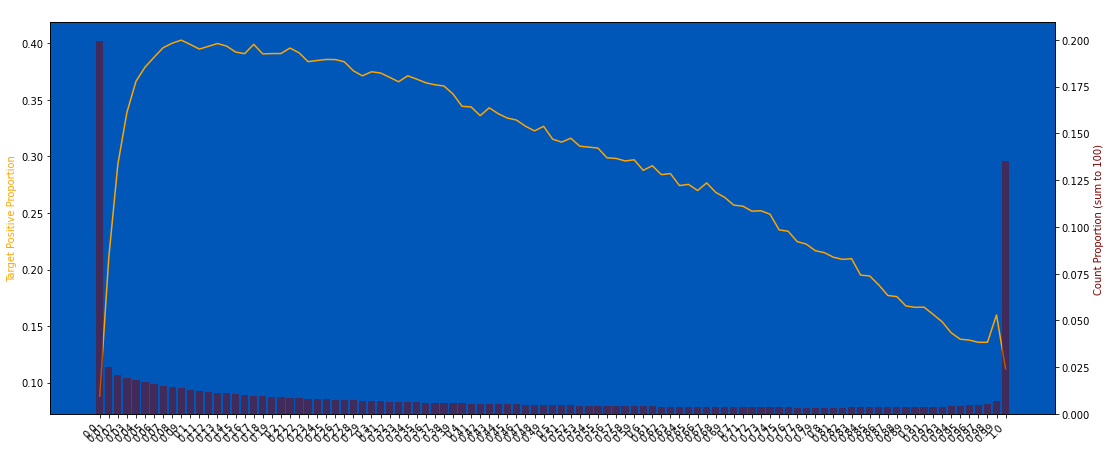

In [129]:
plot_target_check(train, "D_60", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True)

### D_61 @Continuous, Increasing

In [130]:
# plot_target_check(train, "D_61", q=50, use_raw_bin=True)

In [131]:
print_percentile(df_list, "D_61", 99.99)

99.99th percentile:
train : 2.33
public test : 17.93
private test : 17.29


In [132]:
for df in df_list:
    df = clip_col(df, "D_61", top_value=1.5, add_new_col=False)

In [133]:
for df in df_list:
    df.loc[(df["D_61"] == 0.27) & (df["D_55"] == 0), "D_61"] = 1.5
    df.loc[(df["D_61"] == 0.27) & (df["D_55"] == 0), "D_55"] = np.nan

598052 null count, 0.108 null proportion
0.0849 of the targets have label = 1


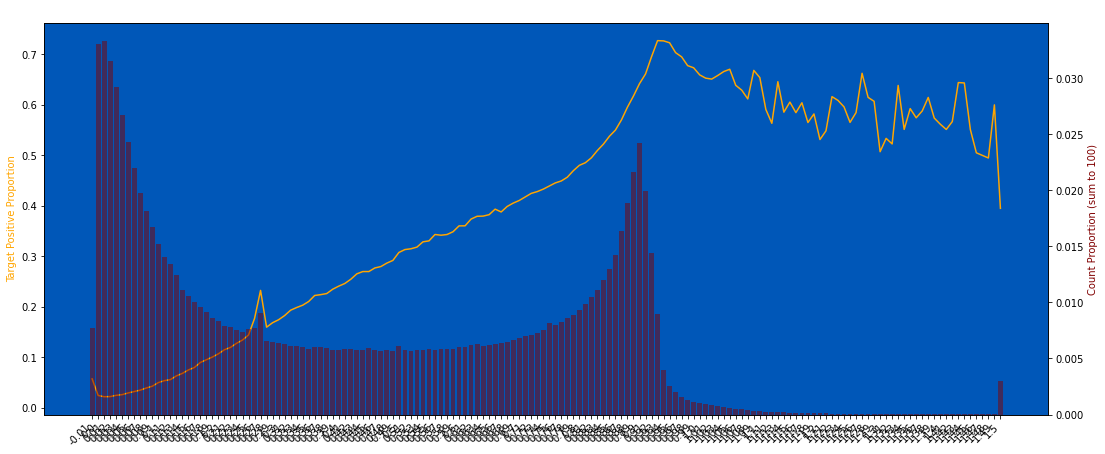

In [134]:
plot_target_check(train, "D_61", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

In [135]:
# plot_train_test_distribution(df_list, "D_61", nunique_thr=1000)

### D_62 @Continuous, Decreasing

In [136]:
# plot_target_check(train, "D_62", q=50, use_raw_bin=True)

In [137]:
print_percentile(df_list, "D_62", 99.9)

99.9th percentile:
train : 1.63
public test : 1.63
private test : 1.63


In [138]:
for df in df_list:
    df = clip_col(df, "D_62", top_value=1.63, add_new_col=False)

758161 null count, 0.137 null proportion
0.1127 of the targets have label = 1


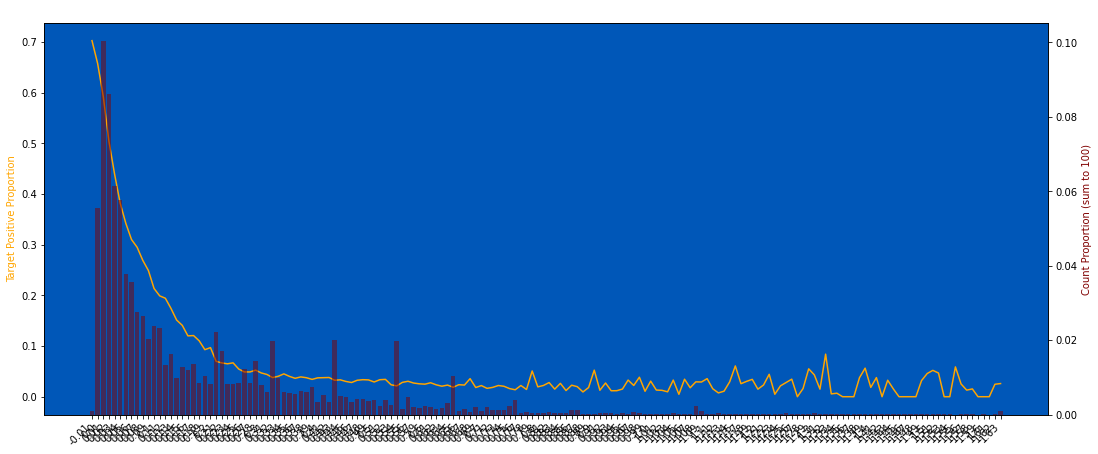

In [139]:
plot_target_check(train, "D_62", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

In [140]:
# plot_train_test_distribution(df_list, "D_62", nunique_thr=1000)

### D_63 @Category

In [141]:
mapping = dict(train.groupby(["D_63"])["target"].mean())
mapping

{'CL': 0.2908939528730126,
 'CO': 0.2628171377901025,
 'CR': 0.16986495479678712,
 'XL': 0.3174443646805456,
 'XM': 0.23740053050397877,
 'XZ': 0.19091755216008688}

In [142]:
for df in df_list:
    df["D_63"] = df["D_63"].map(mapping)

In [143]:
for df in df_list:
    df["D_63"] = df["D_63"].astype("category").cat.codes

0 null count, 0.000 null proportion
nan of the targets have label = 1


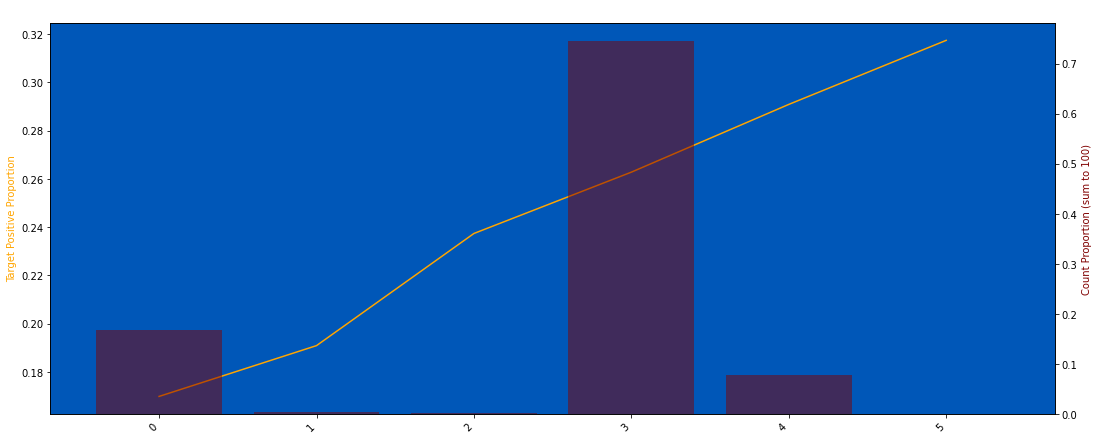

In [144]:
plot_target_check(train, "D_63", q=50, use_raw_bin=True, strfy_x=True, without_drop_tail=True)

In [145]:
# plot_train_test_distribution(df_list, "D_63", nunique_thr=1000, without_drop_tail=True)

### D_64 @Category

In [146]:
mapping = dict(train.groupby(["D_64"])["target"].mean())
mapping

{'-1': 0.2207230210993146,
 'O': 0.16925461787615456,
 'R': 0.31524249147732686,
 'U': 0.3432227420955622}

In [147]:
for df in df_list:
    df["D_64"] = df["D_64"].replace("-1", "R").map(mapping)

In [148]:
for df in df_list:
    df["D_64"] = df["D_64"].astype("category").cat.codes
    df["D_64"] = df["D_64"].replace(-1, 3)

0 null count, 0.000 null proportion
nan of the targets have label = 1
Top & Bottom 1% are dropped from this chart


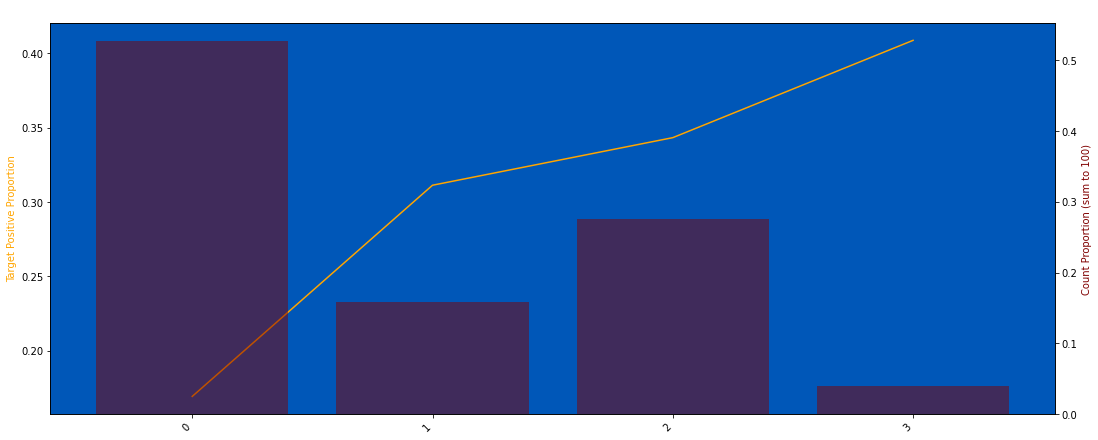

In [149]:
plot_target_check(train, "D_64", q=200, use_raw_bin=True, nunique_thr=10000, strfy_x=True, without_drop_tail=False)

In [150]:
# plot_train_test_distribution(df_list, "D_64", nunique_thr=1000, without_drop_tail=True)

### D_65 @Continuous, Increasing

In [151]:
# plot_target_check(train, "D_65", q=200, use_raw_bin=True, nunique_thr=1000)

In [152]:
for df in df_list:
    df["D_65"] = df["D_65"].replace(0, np.nan)

In [153]:
print_percentile(df_list, "D_65", 99.9)

99.9th percentile:
train : 16.69532000000065
public test : 15.641280000000553
private test : 15.448850000003587


In [154]:
for df in df_list:
    df = clip_col(df, "D_65", top_value=15, add_new_col=False)

5293716 null count, 0.957 null proportion
0.2315 of the targets have label = 1
Top & Bottom 1% are dropped from this chart


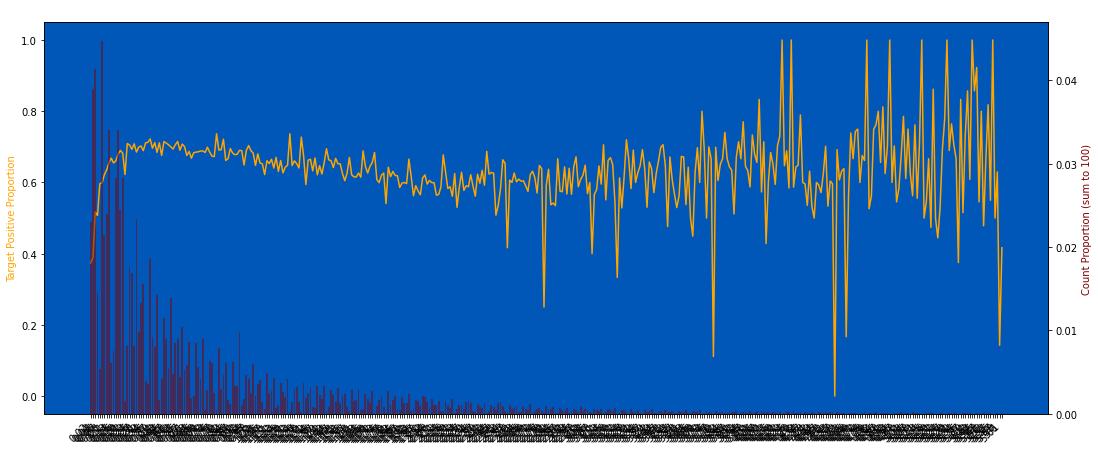

In [155]:
plot_target_check(train, "D_65", q=200, use_raw_bin=True, nunique_thr=10000, strfy_x=True, without_drop_tail=False)

In [156]:
# plot_train_test_distribution(df_list, "D_65", nunique_thr=10000)

### D_68 @Category

In [157]:
describe_all(df_list, "D_68")

,train,public test,private test
count,"5,314,948.0000","5,528,510.0000","5,486,756.0000"
mean,5.0120,5.0059,5.0017
std,1.3513,1.3275,1.3241
min,0.0000,1.0000,1.0000
25%,4.0000,4.0000,4.0000
50%,6.0000,6.0000,6.0000
75%,6.0000,6.0000,6.0000
max,6.0000,6.0000,6.0000
null_proportion,0.0391,0.0334,0.0279


In [158]:
mapping = dict(train.groupby(["D_68"])["target"].mean())
mapping

{0.0: 0.17971742543171115,
 1.0: 0.4039903246645934,
 2.0: 0.3929017632012939,
 3.0: 0.3697800768719475,
 4.0: 0.3436032414965202,
 5.0: 0.26221887882726724,
 6.0: 0.17495197586304181}

In [159]:
for df in df_list:
    df["D_68"] = df["D_68"].replace(0, 6).map(mapping)
    df["D_68"] = df["D_68"].astype("category").cat.codes
    df["D_68"] = df["D_68"].replace(-1, 6)

0 null count, 0.000 null proportion
nan of the targets have label = 1


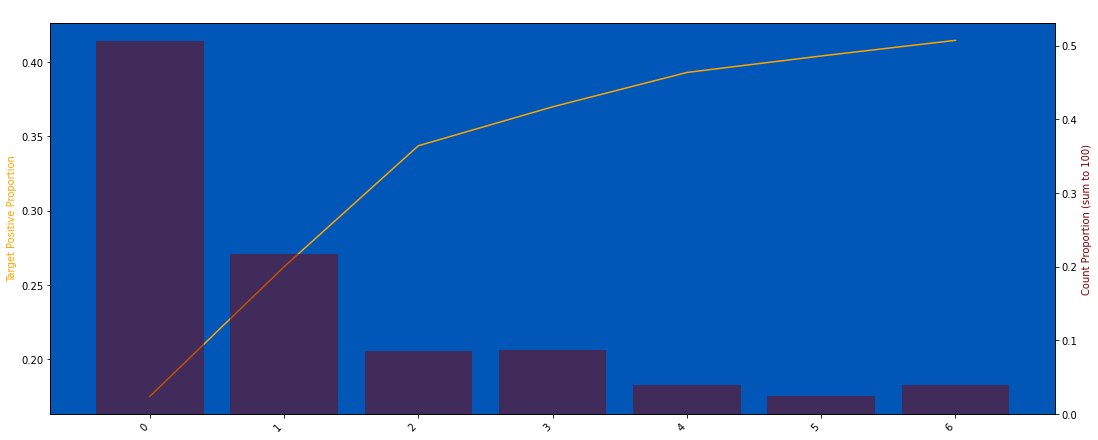

In [160]:
plot_target_check(train, "D_68", q=50, use_raw_bin=True, nunique_thr=50, strfy_x=True, without_drop_tail=True)

### D_69 @Binary, Increasing

In [161]:
# plot_target_check(train, "D_69", q=50, use_raw_bin=True)

In [162]:
for df in df_list:
    df["D_69"] = df["D_69"].fillna(1)
    df["D_69"] = np.where(df["D_69"] > 0, 1, 0)

0 null count, 0.000 null proportion
nan of the targets have label = 1


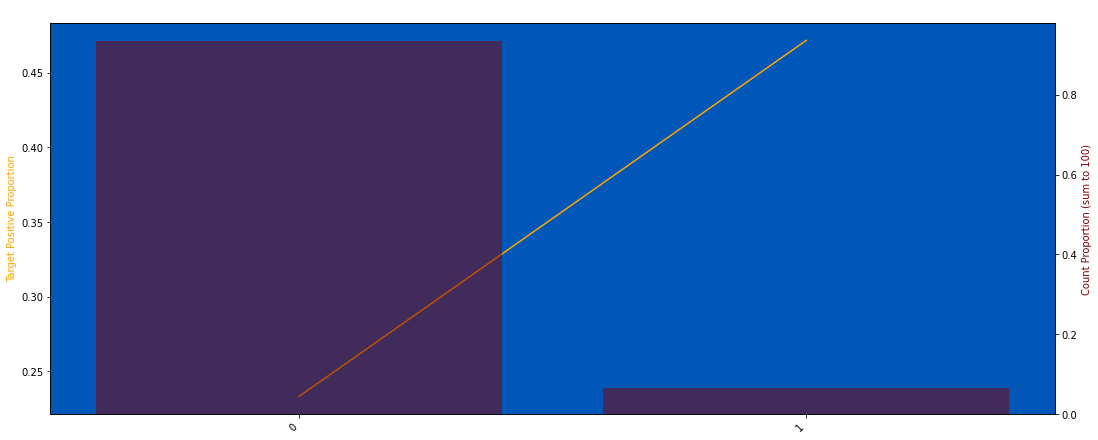

In [163]:
plot_target_check(train, "D_69", q=100, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

In [164]:
# plot_train_test_distribution(df_list, "D_69", nunique_thr=5000)

### D_70 @Integer, Increasing

In [165]:
# plot_target_check(train, "D_70", q=50, use_raw_bin=True)

In [166]:
for df in df_list:
    df["D_70"] = (df["D_70"] * 4).round(0)

In [167]:
print_percentile(df_list, "D_70", 99.9)

99.9th percentile:
train : 8.0
public test : 8.0
private test : 8.0


In [168]:
for df in df_list:
    df = clip_col(df, "D_70", top_value=8, add_new_col=False)

94917 null count, 0.017 null proportion
0.4203 of the targets have label = 1


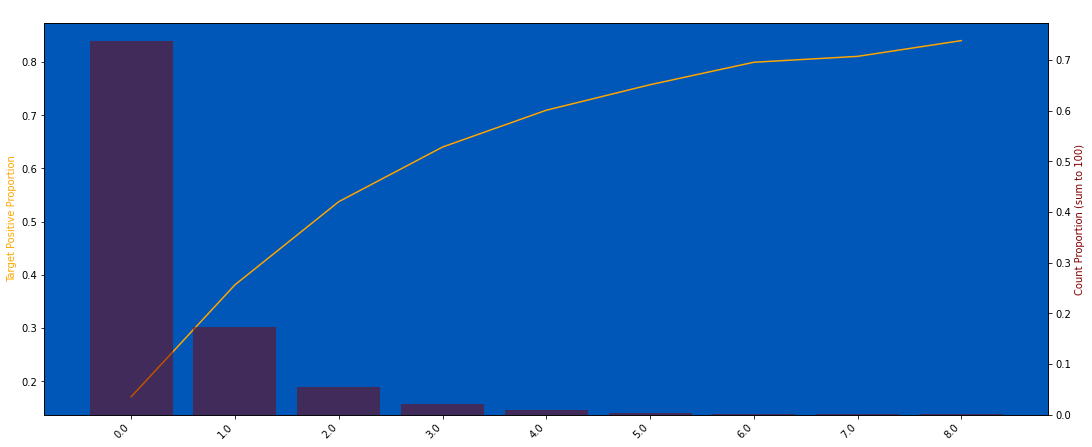

In [169]:
plot_target_check(train, "D_70", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True, without_drop_tail=True)

In [170]:
# plot_train_test_distribution(df_list, "D_70", nunique_thr=5000, without_drop_tail=True)

### D_71 @Continuous, Decreasing

In [171]:
# plot_target_check(train, "D_71", q=50, use_raw_bin=True)

In [172]:
describe_all(df_list, "D_71")

,train,public test,private test
count,"5,531,451.0000","5,719,469.0000","5,644,293.0000"
mean,0.0658,0.0669,0.0701
std,0.3260,0.3309,0.3335
min,0.0000,0.0000,0.0000
25%,0.0000,0.0000,0.0000
50%,0.0100,0.0100,0.0100
75%,0.0300,0.0200,0.0300
max,67.0300,67.0200,59.3500
null_proportion,0.0000,0.0000,0.0000


In [173]:
for df in df_list:
    df["D_71"] = df["D_71"].replace(0.01, np.nan)
    df["D_71"] = df["D_71"].replace(0, 0.01)

In [174]:
print_percentile(df_list, "D_71", 99.5)

99.5th percentile:
train : 1.92
public test : 1.97
private test : 2.02


In [175]:
for df in df_list:
    df = clip_col(df, "D_71", top_value=2, add_new_col=False)

1989047 null count, 0.360 null proportion
0.2427 of the targets have label = 1


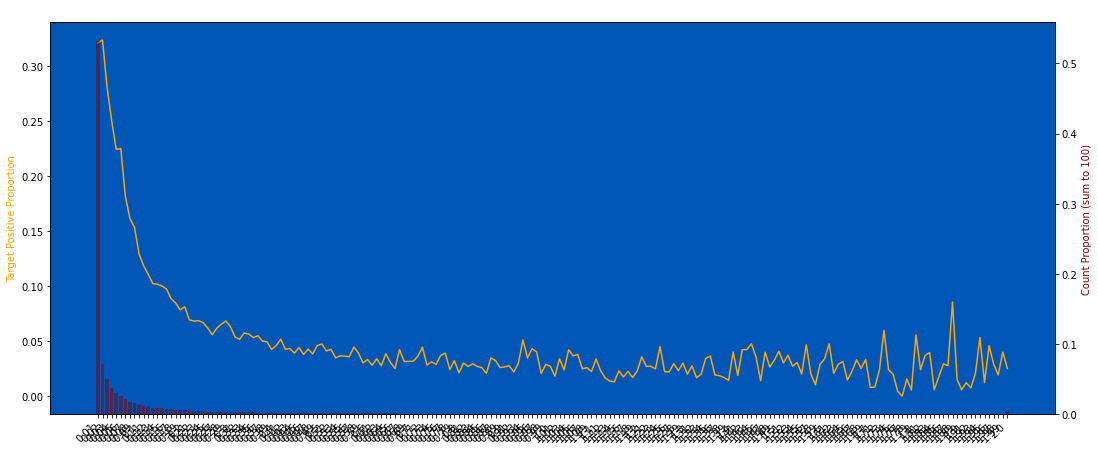

In [176]:
plot_target_check(train, "D_71", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

In [177]:
# plot_train_test_distribution(df_list, "D_71", nunique_thr=5000)

### D_72 Integer, Increasing

In [178]:
# plot_target_check(train, "D_72", q=50, use_raw_bin=True)

In [179]:
for df in df_list:
    df["D_72"] = (df["D_72"] * 3).round(0)

In [180]:
print_percentile(df_list, "D_72", 99.9)

99.9th percentile:
train : 9.0
public test : 9.0
private test : 9.0


In [181]:
for df in df_list:
    df = clip_col(df, "D_72", top_value=4, add_new_col=False)

23708 null count, 0.004 null proportion
0.3495 of the targets have label = 1


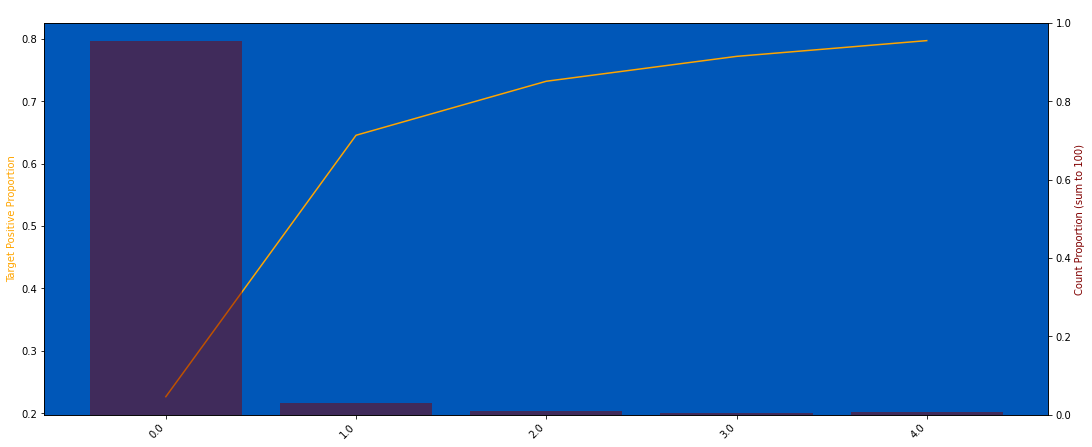

In [182]:
plot_target_check(train, "D_72", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True, without_drop_tail=True)

In [183]:
# plot_train_test_distribution(df_list, "D_72", nunique_thr=5000, without_drop_tail=True)

### D_74 @Integer, Increasing

In [184]:
# plot_target_check(train, "D_74", q=50, use_raw_bin=True)

In [185]:
%%time
for df in df_list:
    df["D_74"] = (df["D_74"] / 0.071)
df_list = round_dfs(df_list, col="D_74", decimals=0, add_new_col=False)

CPU times: user 1.19 s, sys: 2.67 s, total: 3.86 s
Wall time: 4.54 s


In [186]:
print_percentile(df_list, "D_74", 99.9)

99.9th percentile:
train : 23.0
public test : 23.0
private test : 23.0


In [187]:
for df in df_list:
    df = clip_col(df, "D_74", top_value=25, add_new_col=False)

21773 null count, 0.004 null proportion
0.1709 of the targets have label = 1


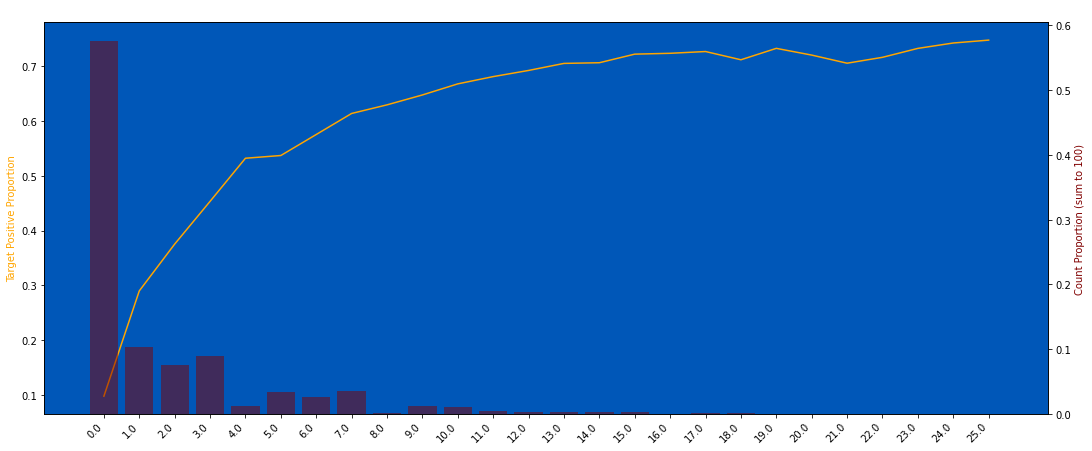

In [188]:
plot_target_check(train, "D_74", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True, without_drop_tail=True)

In [189]:
# plot_train_test_distribution(df_list, "D_74", nunique_thr=5000, without_drop_tail=True)

### D_75 @Integer, Increasing

In [190]:
# plot_target_check(train, "D_75", q=50, use_raw_bin=True)

In [191]:
for df in df_list:
    df["D_75"] = (df["D_75"] * (100 / 6.66)).round(0)

In [192]:
print_percentile(df_list, "D_75", 99.9)

99.9th percentile:
train : 24.0
public test : 24.0
private test : 25.0


In [193]:
for df in df_list:
    df = clip_col(df, "D_75", top_value=25, add_new_col=False)

0 null count, 0.000 null proportion
nan of the targets have label = 1


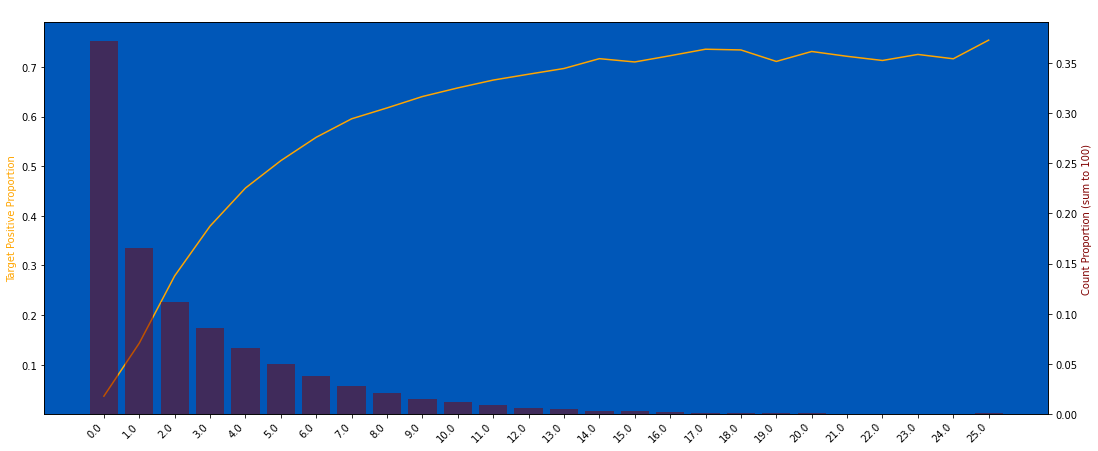

In [194]:
plot_target_check(train, "D_75", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True, without_drop_tail=True)

In [195]:
# plot_train_test_distribution(df_list, "D_75", nunique_thr=5000, without_drop_tail=True)

### D_76 @Continuous, Decreasing

In [196]:
print_percentile(df_list, "D_76", 99)

99th percentile:
train : 1.0
public test : 1.07
private test : 1.14


In [197]:
for df in df_list:
    df = clip_col(df, "D_76", top_value=1, add_new_col=False)

4908954 null count, 0.887 null proportion
0.2677 of the targets have label = 1


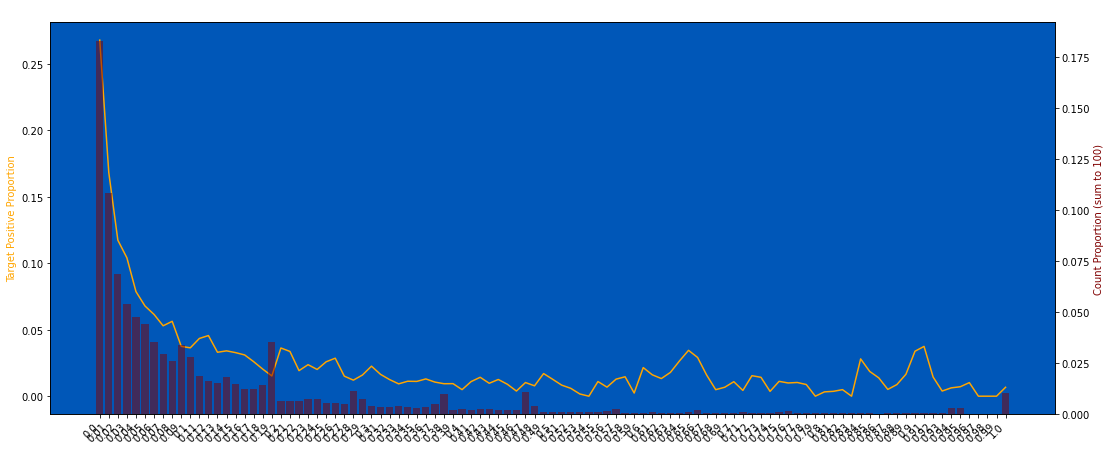

In [198]:
plot_target_check(train, "D_76", q=50, use_raw_bin=True, nunique_thr=2000, strfy_x=True)

In [199]:
# plot_train_test_distribution(df_list, "D_76", nunique_thr=5000)

### D_77 @Continuous, Decreasing

In [200]:
# plot_target_check(train, "D_77", q=50, use_raw_bin=True)

In [201]:
print_percentile(df_list, "D_77", 99.3)

99.3th percentile:
train : 1.05
public test : 1.05
private test : 1.06


In [202]:
for df in df_list:
    df = clip_col(df, "D_77", top_value=1.01, add_new_col=False)

2513912 null count, 0.454 null proportion
0.3395 of the targets have label = 1


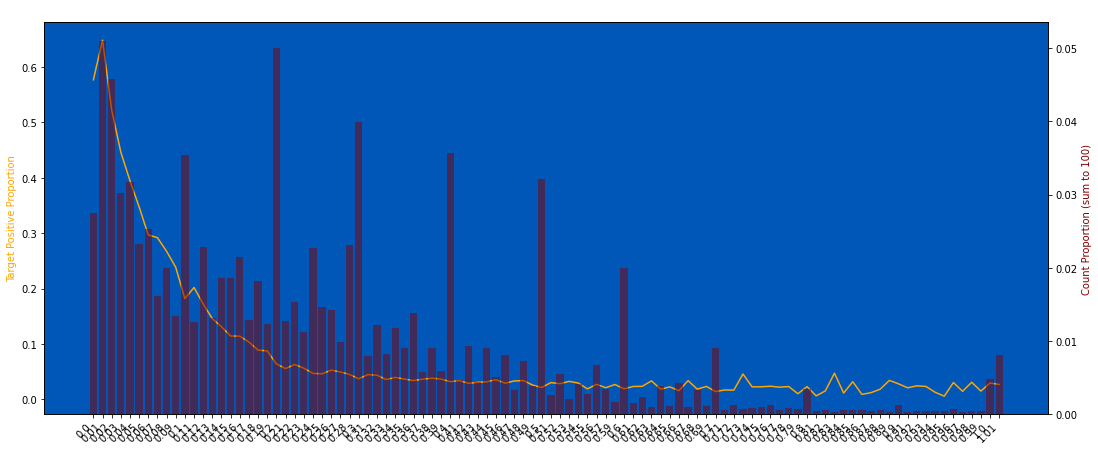

In [203]:
plot_target_check(train, "D_77", q=50, use_raw_bin=True, nunique_thr=2000, strfy_x=True, without_drop_tail=True)

In [204]:
# plot_train_test_distribution(df_list, "D_77", nunique_thr=5000)

### D_78 @Integer, Increasing

In [205]:
# plot_target_check(train, "D_78", q=50, use_raw_bin=True)

In [206]:
for df in df_list:
    df["D_78"] = (df["D_78"] * 2).round(0)

In [207]:
print_percentile(df_list, "D_78", 99.9)

99.9th percentile:
train : 6.0
public test : 6.0
private test : 6.0


In [208]:
for df in df_list:
    df = clip_col(df, "D_78", top_value=4, add_new_col=False)

274319 null count, 0.050 null proportion
0.2406 of the targets have label = 1


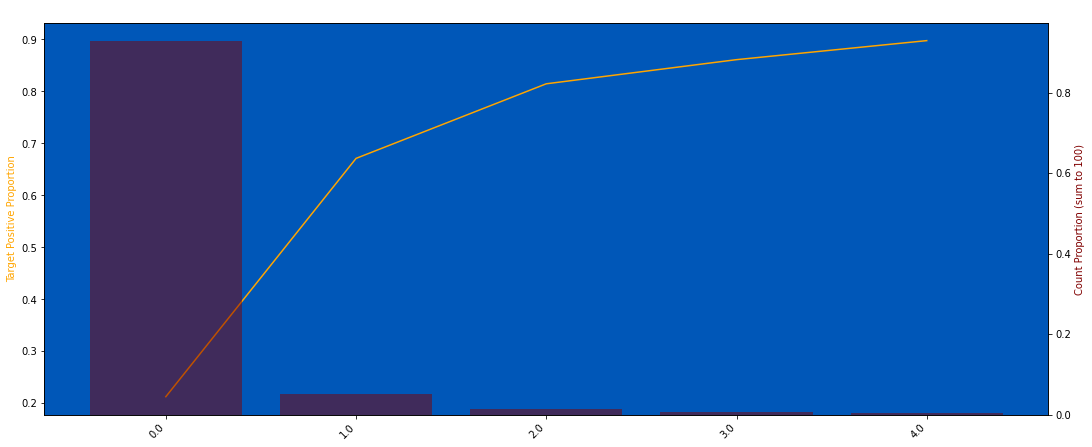

In [209]:
plot_target_check(train, "D_78", q=50, use_raw_bin=True, nunique_thr=100, strfy_x=True, without_drop_tail=True)

In [210]:
# plot_train_test_distribution(df_list, "D_78", nunique_thr=500, without_drop_tail=True)

### D_79 @Integer, Increasing

In [211]:
# plot_target_check(train, "D_79", q=50, use_raw_bin=True)

In [212]:
for df in df_list:
    df["D_79"] = (df["D_79"] * 2).round(0)

In [213]:
print_percentile(df_list, "D_79", 99.7)

99.7th percentile:
train : 3.0
public test : 3.0
private test : 3.0


In [214]:
for df in df_list:
    df = clip_col(df, "D_79", top_value=4, add_new_col=False)

75939 null count, 0.014 null proportion
0.3761 of the targets have label = 1


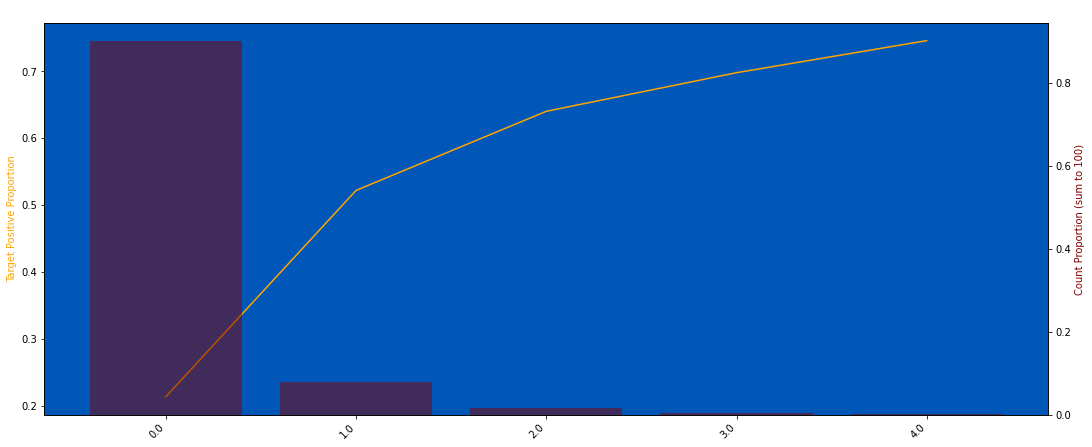

In [215]:
plot_target_check(train, "D_79", q=50, use_raw_bin=True, nunique_thr=100, strfy_x=True, without_drop_tail=True)

In [216]:
# plot_train_test_distribution(df_list, "D_79", nunique_thr=500, without_drop_tail=True)

### D_80 @Integer, Increasing

In [217]:
# plot_target_check(train, "D_80", q=50, use_raw_bin=True)

In [218]:
for df in df_list:
    df["D_80"] = (df["D_80"] * 5).round(0)

In [219]:
print_percentile(df_list, "D_80", 99.9)

99.9th percentile:
train : 9.0
public test : 9.0
private test : 9.0


In [220]:
for df in df_list:
    df = clip_col(df, "D_80", top_value=9, add_new_col=False)

21773 null count, 0.004 null proportion
0.1709 of the targets have label = 1


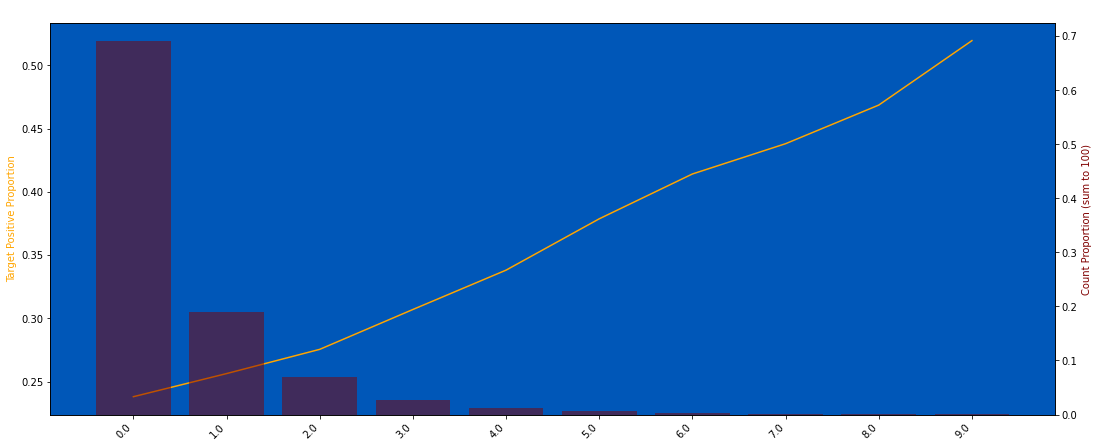

In [221]:
plot_target_check(train, "D_80", q=50, use_raw_bin=True, nunique_thr=100, strfy_x=True, without_drop_tail=True)

In [222]:
# plot_train_test_distribution(df_list, "D_80", nunique_thr=500, without_drop_tail=True)

### D_82 @Integer, Increasing

In [223]:
# plot_target_check(train, "D_82", q=50, use_raw_bin=True)

In [224]:
print_percentile(df_list, "D_82", 99.9)

99.9th percentile:
train : 1.5
public test : 1.5
private test : 1.5


In [225]:
for df in df_list:
    df["D_82"] = (df["D_82"] * 2).round(0)
    df = clip_col(df, "D_82", top_value=2, add_new_col=False)
    df["D_82"] = df["D_82"].fillna(2)

0 null count, 0.000 null proportion
nan of the targets have label = 1


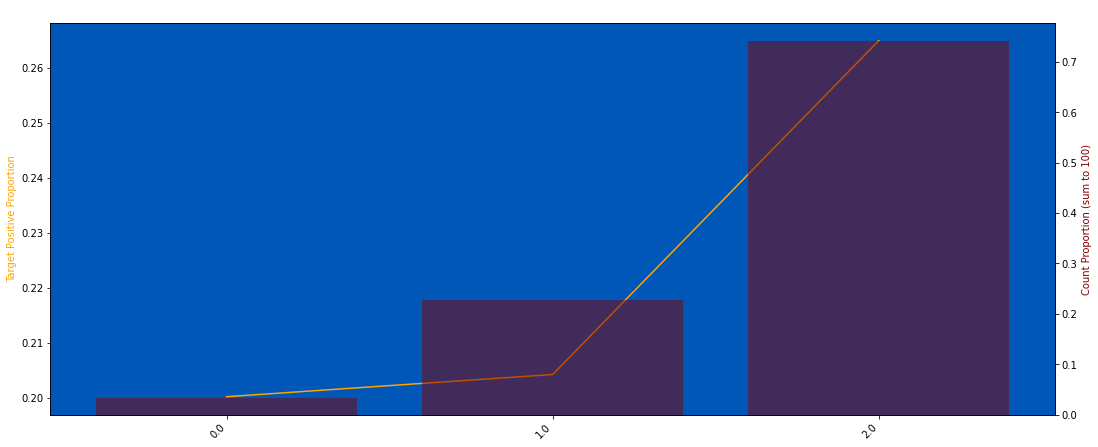

In [226]:
plot_target_check(train, "D_82", q=50, use_raw_bin=True, nunique_thr=3000, strfy_x=True, without_drop_tail=True)

In [227]:
# plot_train_test_distribution(df_list, "D_82", nunique_thr=500, without_drop_tail=True)

### D_84 @Integer, Increasing

In [228]:
# plot_target_check(train, "D_84", q=50, use_raw_bin=True)

In [229]:
for df in df_list:
    df["D_84"] = (df["D_84"] * 2).round(0)
    df["D_84"] = df["D_84"].fillna(1)

In [230]:
print_percentile(df_list, "D_84", 99.8)

99.8th percentile:
train : 6.0
public test : 6.0
private test : 6.0


In [231]:
for df in df_list:
    df = clip_col(df, "D_84", top_value=2, add_new_col=False)

0 null count, 0.000 null proportion
nan of the targets have label = 1


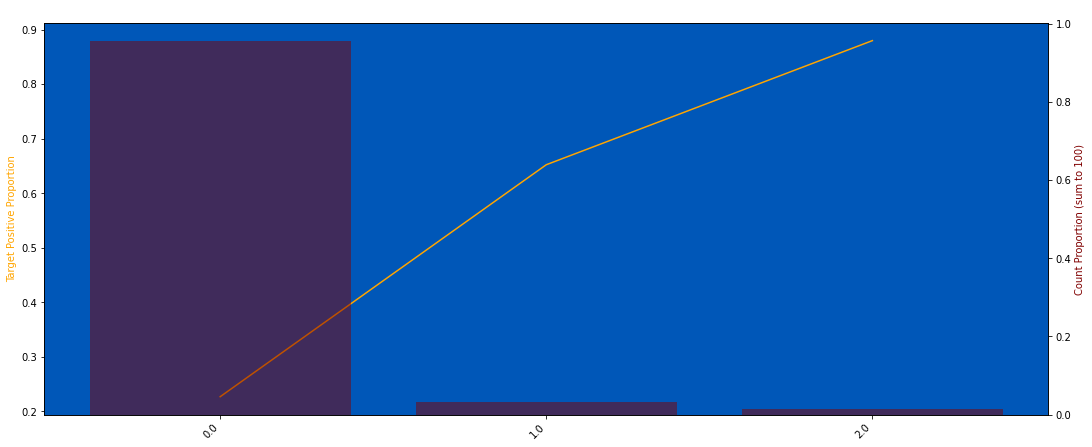

In [232]:
plot_target_check(train, "D_84", q=50, use_raw_bin=True, without_drop_tail=True, strfy_x=True)

In [233]:
# plot_train_test_distribution(df_list, "D_84", nunique_thr=500, without_drop_tail=True)

### D_91 @Integer, Decreasing

In [234]:
# plot_target_check(train, "D_91", q=50, use_raw_bin=True)

In [235]:
print_percentile(df_list, "D_91", 99.9)

99.9th percentile:
train : 1.5
public test : 1.5
private test : 1.5


In [236]:
for df in df_list:
    df["D_91"] *= 2
    df = clip_col(df, "D_91", top_value=3, add_new_col=False)

157216 null count, 0.028 null proportion
0.4663 of the targets have label = 1


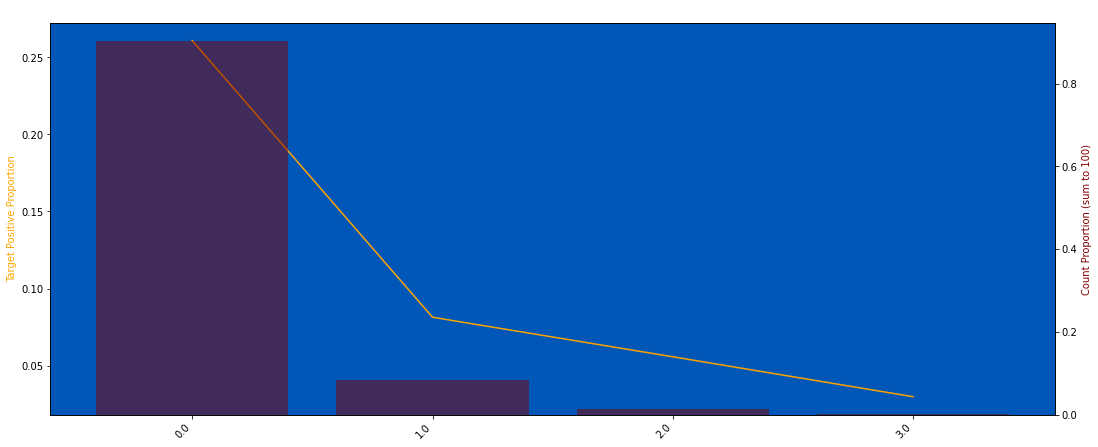

In [237]:
plot_target_check(train, "D_91", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

In [238]:
# plot_train_test_distribution(df_list, "D_91", nunique_thr=12)

### Column checking

In [239]:
all_columns = get_cols(df_list[0], ["D_"])
print(all_columns)

['D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_46', 'D_47', 'D_48', 'D_49', 'D_50', 'D_51', 'D_52', 'D_53', 'D_54', 'D_55', 'D_56', 'D_58', 'D_60', 'D_61', 'D_62', 'D_63', 'D_64', 'D_65', 'D_68', 'D_69', 'D_70', 'D_71', 'D_72', 'D_74', 'D_75', 'D_76', 'D_77', 'D_78', 'D_79', 'D_80', 'D_81', 'D_82', 'D_83', 'D_84', 'D_87', 'D_91', 'D_99', 'D_888', 'D_813']


In [240]:
%%time
d_col_nunique = df_list[0][all_columns].nunique()
less_unique_d_cols = d_col_nunique[d_col_nunique < 99].index.tolist()

CPU times: user 2.46 s, sys: 422 ms, total: 2.88 s
Wall time: 2.88 s


In [241]:
print(less_unique_d_cols)

['D_39', 'D_44', 'D_51', 'D_54', 'D_63', 'D_64', 'D_68', 'D_69', 'D_70', 'D_72', 'D_74', 'D_75', 'D_78', 'D_79', 'D_80', 'D_81', 'D_82', 'D_83', 'D_84', 'D_87', 'D_91', 'D_99', 'D_888', 'D_813']


In [242]:
%%time
for col in less_unique_d_cols:
    temp = integerize(train[col])
    if (temp - train[col]).abs().max() < 1e-4:
        print(f"{col} fulfill criteria to convert to integer")
        for df in df_list:
            df[col] = integerize(df[col])

D_39 fulfill criteria to convert to integer
D_44 fulfill criteria to convert to integer
D_51 fulfill criteria to convert to integer
D_54 fulfill criteria to convert to integer
D_63 fulfill criteria to convert to integer
D_64 fulfill criteria to convert to integer
D_68 fulfill criteria to convert to integer
D_69 fulfill criteria to convert to integer
D_70 fulfill criteria to convert to integer
D_72 fulfill criteria to convert to integer
D_74 fulfill criteria to convert to integer
D_75 fulfill criteria to convert to integer
D_78 fulfill criteria to convert to integer
D_79 fulfill criteria to convert to integer
D_80 fulfill criteria to convert to integer
D_81 fulfill criteria to convert to integer
D_82 fulfill criteria to convert to integer
D_83 fulfill criteria to convert to integer
D_84 fulfill criteria to convert to integer
D_87 fulfill criteria to convert to integer
D_91 fulfill criteria to convert to integer
D_99 fulfill criteria to convert to integer
D_888 fulfill criteria to conver

In [243]:
no_use_features = ["temp"] + df_list[0].columns[df_list[0].columns.str.endswith("_")].tolist()
no_use_features

['temp']

In [244]:
%%time
for df in tqdm(df_list):
    df.drop(columns=no_use_features, errors="ignore", inplace=True)

100%|██████████| 3/3 [00:02<00:00,  1.14it/s]

CPU times: user 1.65 s, sys: 989 ms, total: 2.64 s
Wall time: 2.63 s


In [245]:
%%time
float64_columns = train.select_dtypes("float64").columns.tolist()
for col in float64_columns:
    temp = df_list[-1][col].astype(np.float32).values
    if (temp - df_list[-1][col]).abs().max() < 1e-4:
        print(f"{col} fulfill criteria to convert to float32")
        for df in df_list:
            df[col] = df[col].astype(np.float32)

D_41 fulfill criteria to convert to float32
D_42 fulfill criteria to convert to float32
D_43 fulfill criteria to convert to float32
D_46 fulfill criteria to convert to float32
D_47 fulfill criteria to convert to float32
D_48 fulfill criteria to convert to float32
D_49 fulfill criteria to convert to float32
D_50 fulfill criteria to convert to float32
D_52 fulfill criteria to convert to float32
D_53 fulfill criteria to convert to float32
D_55 fulfill criteria to convert to float32
D_56 fulfill criteria to convert to float32
D_58 fulfill criteria to convert to float32
D_60 fulfill criteria to convert to float32
D_61 fulfill criteria to convert to float32
D_62 fulfill criteria to convert to float32
D_65 fulfill criteria to convert to float32
D_71 fulfill criteria to convert to float32
D_76 fulfill criteria to convert to float32
D_77 fulfill criteria to convert to float32
CPU times: user 3.58 s, sys: 2.17 s, total: 5.76 s
Wall time: 5.74 s


In [246]:
%%time
train = df_list[0]
test = pd.concat(df_list[1:], axis=0)
test = test.sort_values(by=["customer_ID", "S_2"]).reset_index(drop=True)

CPU times: user 9.28 s, sys: 1.4 s, total: 10.7 s
Wall time: 10.7 s


In [247]:
train.shape, test.shape

((5531451, 49), (11363762, 48))

In [248]:
sys.getsizeof(train) / 1e9, sys.getsizeof(test) / 1e9

(1.864099003, 3.647767746)

In [249]:
%%time
train.to_parquet(f"./train_parquet/train_delinquency_part1.parquet")
test.to_parquet(f"./test_parquet/test_delinquency_part1.parquet")

CPU times: user 19.6 s, sys: 876 ms, total: 20.5 s
Wall time: 18.9 s


In [250]:
END = time.time()

In [251]:
print(f"{END - START:.2f} seconds elapsed")

249.89 seconds elapsed
